# Practicum II - Using News Headlines to Predict Stock Market Performance - Model Building

Now that I have collected, cleaned, and explored my data, it's time to start with the real meat and potatos of this project: building out my models. In this notebook, I will build 3 models overall. The first one I'll build out is a sentiment analysis type model in which I will assign a sentiment score to each of the headlines I have in the combined dataset and then I'll use those scores from all the headlines in each day to assign an overall sentiment score for that day. The second model I'll build will be a clustering model in which I will cluster the headlines in order to generally categorize the headlines using the clusters that the model comes up with. Finally, I will build out the model we've all been waiting for, the stock market prediction model for trying to predict whether markets will close up or down based on headlines as well as past stock performance. Per usual, let's start with importing the necessary packages and reading in our data:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from datetime import datetime
from wordcloud import WordCloud
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report 
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from keras import Sequential
from keras.layers import Dense

/Users/dsciacca/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DJIA = pd.read_csv('data/cleaned/DJIA.csv')
combined = pd.read_csv('data/cleaned/combined.csv')
headlines = pd.read_csv('data/cleaned/headlines.csv')

print("headlines: ")
display(headlines.head())
print("DJIA: ")
display(DJIA.head())
print("combined_df: ")
display(combined.head())

headlines: 


,Date,News,tokenized,News_cleaned,cleaned_tokenized
0,2016-07-01,A 117 year old woman in Mexico City finally re...,"['A', '117', 'year', 'old', 'woman', 'in', 'Me...",year old woman mexico city finally received bi...,"['year', 'old', 'woman', 'mexico', 'city', 'fi..."
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,"['IMF', 'chief', 'backs', 'Athens', 'as', 'per...",imf chief backs athens permanent olympic host,"['imf', 'chief', 'backs', 'athens', 'permanent..."
2,2016-07-01,The president of France says if Brexit won so ...,"['The', 'president', 'of', 'France', 'says', '...",president france says brexit donald trump,"['president', 'france', 'says', 'brexit', 'don..."
3,2016-07-01,British Man Who Must Give Police 24 Hours Noti...,"['British', 'Man', 'Who', 'Must', 'Give', 'Pol...",british man must give police hours notice sex ...,"['british', 'man', 'must', 'give', 'police', '..."
4,2016-07-01,100 Nobel laureates urge Greenpeace to stop op...,"['100', 'Nobel', 'laureates', 'urge', 'Greenpe...",nobel laureates urge greenpeace stop opposing ...,"['nobel', 'laureates', 'urge', 'greenpeace', '..."


DJIA: 


,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


combined_df: 


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16_cleaned_tokenized,Top17_cleaned_tokenized,Top18_cleaned_tokenized,Top19_cleaned_tokenized,Top20_cleaned_tokenized,Top21_cleaned_tokenized,Top22_cleaned_tokenized,Top23_cleaned_tokenized,Top24_cleaned_tokenized,Top25_cleaned_tokenized
0,2008-08-08,0,Georgia downs two Russian warplanes as countri...,BREAKING Musharraf to be impeached,Russia Today Columns of troops roll into South...,Russian tanks are moving towards the capital o...,Afghan children raped with impunity UN officia...,150 Russian tanks have entered South Ossetia w...,Breaking Georgia invades South Ossetia Russia ...,The enemy combatent trials are nothing but a s...,...,"['georgia', 'invades', 'south', 'ossetia', 'ru...","['al', 'qaeda', 'faces', 'islamist', 'backlash']","['condoleezza', 'rice', 'us', 'would', 'act', ...","['busy', 'day', 'european', 'union', 'approved...","['georgia', 'withdraw', 'soldiers', 'iraq', 'h...","['pentagon', 'thinks', 'attacking', 'iran', 'b...","['caucasus', 'crisis', 'georgia', 'invades', '...","['indian', 'shoe', 'manufactory', 'series', 'l...","['visitors', 'suffering', 'mental', 'illnesses...","['help', 'mexicos', 'kidnapping', 'surge']"
1,2008-08-11,1,Why wont America and Nato help us If they wont...,Bush puts foot down on Georgian conflict,Jewish Georgian minister Thanks to Israeli tra...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in SOssetia blames ...,...,"['israel', 'us', 'behind', 'georgian', 'aggres...","['believe', 'tv', 'neither', 'russian', 'georg...","['riots', 'still', 'going', 'montreal', 'canad...","['china', 'overtake', 'us', 'largest', 'manufa...","['war', 'south', 'ossetia', 'pics']","['israeli', 'physicians', 'group', 'condemns',...","['russia', 'beaten', 'united', 'states', 'head...","['perhaps', 'question', 'georgia', 'russia', '...","['russia', 'much', 'better', 'war']","['come', 'trading', 'sex', 'food']"
2,2008-08-12,0,Remember that adorable 9 year old who sang at ...,Russia ends Georgia operation,If we had no sexual harassment we would have n...,Al Qaeda is losing support in Iraq because of ...,Ceasefire in Georgia Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO 1...,Stratfor The Russo Georgian War and the Balanc...,Im Trying to Get a Sense of This Whole Georgia...,...,"['us', 'troops', 'still', 'georgia', 'know', '...","['russias', 'response', 'georgia', 'right']","['gorbachev', 'accuses', 'us', 'making', 'seri...","['russia', 'georgia', 'nato', 'cold', 'war', '...","['remember', 'adorable', 'year', 'old', 'led',...","['war', 'georgia', 'israeli', 'connection']","['signs', 'point', 'us', 'encouraging', 'georg...","['christopher', 'king', 'argues', 'us', 'nato'...","['america', 'new', 'mexico']","['bbc', 'news', 'asia', 'pacific', 'extinction..."
3,2008-08-13,0,US refuses Israel weapons to attack Iran report,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,Britain\s policy of being tough on drugs is po...,Body of 14 year old found in trunk Latest rans...,China has moved 10 million quake survivors int...,Bush announces Operation Get All Up In Russias...,Russian forces sink Georgian ships,...,"['elephants', 'extinct']","['us', 'humanitarian', 'missions', 'soon', 'ge...","['georgias', 'ddos', 'came', 'us', 'sources']","['russian', 'convoy', 'heads', 'georgia', 'vio...","['israeli', 'defence', 'minister', 'us', 'stri...","['gorbachev', 'choice']","['witness', 'russian', 'forces', 'head', 'towa...","['quarter', 'russians', 'blame', 'us', 'confli...","['georgian', 'president', 'says', 'us', 'milit...","['nobel', 'laureate', 'aleksander', 'solzhenit..."
4,2008-08-14,1,All the experts admit that we should legalise ...,War in South Osetia 89 pictures made by a Ru...,Swedish wrestler Ara Abrahamian throws away me

Great, now that everything is in place, lets get started. The first thing I want to do is some sentiment analysis. The `textblob` package makes this extremely easy where I just have to convert the text I want to analyze to a TextBlob object and then I can obtain information about the sentiment of that blob using using the `polarity` (i.e. a score of positive or negative) and `subjectivity` (i.e. a score representing how subjective a statement is) properties. Let's give this a go on the headlines dataset first creating polarity and subjectivity columns with scores for each headline:

In [3]:
# create empty lists to hold polarity and subjectivity scores
polarity = list()
subjectivity = list()

# loop through each headlines in the news dataset. Sticking with non-cleaned column because TextBlob is very flexible
for headline in tqdm_notebook(headlines['News'], desc = "Headlines Processed:"):
    # convert headline to TextBlob object
    blob = TextBlob(headline)
    # Append polarity and subjectivity scores to respective lists
    polarity.append(blob.polarity)
    subjectivity.append(blob.subjectivity)
    
# create polarity and subjectivity columns
headlines['polarity'] = polarity
headlines['subjectivity'] = subjectivity

headlines.head()

,Date,News,tokenized,News_cleaned,cleaned_tokenized,polarity,subjectivity
0,2016-07-01,A 117 year old woman in Mexico City finally re...,"['A', '117', 'year', 'old', 'woman', 'in', 'Me...",year old woman mexico city finally received bi...,"['year', 'old', 'woman', 'mexico', 'city', 'fi...",-0.025000,0.325000
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,"['IMF', 'chief', 'backs', 'Athens', 'as', 'per...",imf chief backs athens permanent olympic host,"['imf', 'chief', 'backs', 'athens', 'permanent...",0.000000,0.000000
2,2016-07-01,The president of France says if Brexit won so ...,"['The', 'president', 'of', 'France', 'says', '...",president france says brexit donald trump,"['president', 'france', 'says', 'brexit', 'don...",0.000000,0.000000
3,2016-07-01,British Man Who Must Give Police 24 Hours Noti...,"['British', 'Man', 'Who', 'Must', 'Give', 'Pol...",british man must give police hours notice sex ...,"['british', 'man', 'must', 'give', 'police', '...",0.111111,0.388889
4,2016-07-01,100 Nobel laureates urge Greenpeace to stop op...,"['100', 'Nobel', 'laureates', 'urge', 'Greenpe...",nobel laureates urge greenpeace stop opposing ...,"['nobel', 'laureates', 'urge', 'greenpeace', '...",0.000000,0.000000


Perfect! I was a bit concerned that I was going to end up with unusable scores accross the board for the headlines since they are composed of so many nouns and things that don't necessarily have a polarity or subjectivity associated with them. There are still a number that have scores of 0, but still a few more informative scores which is good. Before doing this with the combined dataset, I'd like to see the distributions of polarity and subjectivity in this corpus of headlines because I worry that there weren't many headlines with sentiment scores due to the common frequency of nouns and other words that don't necessarily have a sentiment score:

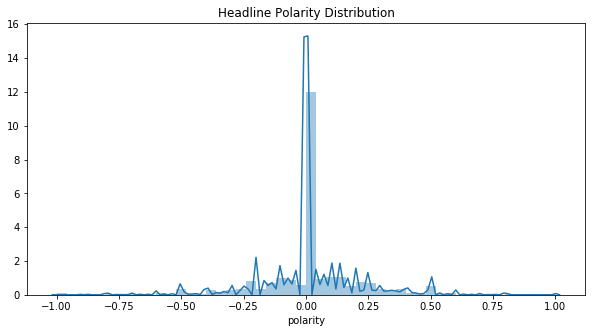

In [4]:
plt.figure(figsize=(10, 5))
sns.distplot(headlines['polarity'])
plt.title("Headline Polarity Distribution")
plt.savefig('visualizations/distplots/headline_polarity.png')

Clearly in this plot there are a lot of polarity scores of 0, telling me that my concerns weren’t completely unfounded. Even still, there’s still a decent amount of headlines that did receive a polarity score. Something that surprised me was that, if anything, there seems to be more positive polarity than negative. This surprised me because I’m so used to associating news headlines with negativity and bad things happening in the world! Now let's check out the subjectivity distribution:

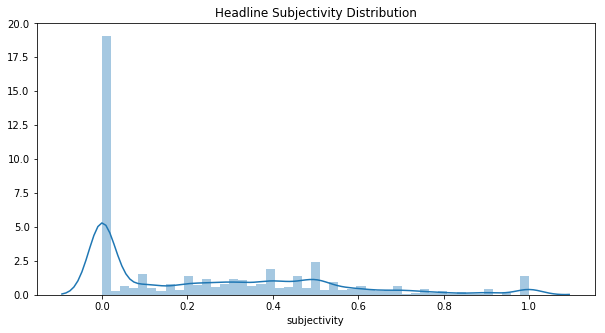

In [5]:
plt.figure(figsize=(10, 5))
sns.distplot(headlines['subjectivity'])
plt.title("Headline Subjectivity Distribution")
plt.savefig('visualizations/distplots/headline_subjectivity.png')

The above subjectivity distribution plot shows a similar pattern to the polarity plot: most headlines have a subjectivity of 0. It’s hard to determine, though, whether or not this is just good journalism as journalists are really supposed to report the facts and not focus so much on opinion or if this is an artifact related to my concerns about high frequency of nouns and such. Either way, I found this to be pretty interesting, especially that, for the most part, those headlines tagged as having some amount of subjectivity fall on the lower side of the spectrum.

Now let's do this with the combined dataset, making a polarity and subjectivity column for each of the `Top#` columns:

In [6]:
cols = [col for col in list(combined.columns) if col.startswith("Top") and "_" not in col]
# loop through the Top# columns of the combined dataset
for col in tqdm_notebook(cols, desc = "Top# Columns Processed:"):
    # reinitialize lists to empty lists
    polarity = list()
    subjectivity = list()
    # cast col to str as some had only numbers
    combined[col] = combined[col].astype(str)
    # loop through each headline in the column
    for headline in combined[col]:
        # cast headline to textblob object
        blob = TextBlob(headline)
        # Append polarity and subjectivity scores to respective lists
        polarity.append(blob.polarity)
        subjectivity.append(blob.subjectivity)
    # create polarity and subjectivity columns for each Top#
    combined[col + "_polarity"] = polarity
    combined[col + "_subjectivity"] = subjectivity
combined.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top21_polarity,Top21_subjectivity,Top22_polarity,Top22_subjectivity,Top23_polarity,Top23_subjectivity,Top24_polarity,Top24_subjectivity,Top25_polarity,Top25_subjectivity
0,2008-08-08,0,Georgia downs two Russian warplanes as countri...,BREAKING Musharraf to be impeached,Russia Today Columns of troops roll into South...,Russian tanks are moving towards the capital o...,Afghan children raped with impunity UN officia...,150 Russian tanks have entered South Ossetia w...,Breaking Georgia invades South Ossetia Russia ...,The enemy combatent trials are nothing but a s...,...,-0.7,0.666667,0.0,0.0,0.0,0.00,-0.100000,0.200000,0.0,0.0
1,2008-08-11,1,Why wont America and Nato help us If they wont...,Bush puts foot down on Georgian conflict,Jewish Georgian minister Thanks to Israeli tra...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in SOssetia blames ...,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.500000,0.500000,0.0,0.0
2,2008-08-12,0,Remember that adorable 9 year old who sang at ...,Russia ends Georgia operation,If we had no sexual harassment we would have n...,Al Qaeda is losing support in Iraq because of ...,Ceasefire in Georgia Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO 1...,Stratfor The Russo Georgian War and the Balanc...,Im Trying to Get a Sense of This Whole Georgia...,...,0.0,0.000000,0.0,0.0,-0.2,0.35,0.136364,0.454545,0.0,0.0
3,2008-08-13,0,US refuses Israel weapons to attack Iran report,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,Britain\s policy of being tough on drugs is po...,Body of 14 year old found in trunk Latest rans...,China has moved 10 million quake survivors int...,Bush announces Operation Get All Up In Russias...,Russian forces sink Georgian ships,...,0.0,0.000000,0.0,0.0,0.0,0.00,-0.100000,0.100000,0.0,0.0
4,2008-08-14,1,All the experts admit that we should legalise ...,War in South Osetia 89 pictures made by a Ru...,Swedish wrestler Ara Abrahamian throws away me...,Russia exaggerated the death toll in South Oss...,Missile That Killed 9 Inside Pakistan May Have...,Rushdie Condemns Random Houses Refusal to Publ...,Poland and US agree to missle defense deal Int...,Will the Russians conquer Tblisi Bet on it no ...,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.062500,0.500000,0.0,0.0


Awesome! Now this is all well and good, but I'm not sure how much individual polarity and subjectivity scores for each of the top 25 headlines from a day will have that much weight in the final model, so I'd like to get overall polarity and subjectivity scores for the headlines from each day as I feel this may be more useful for my final predictions. To do this, I will convert all the headlines from each day into a single text blob and analyze the sentiment on that:

In [7]:
# Initialize empty lists
polarity = list()
subjectivity = list()
# loop through every row in the dataset
for i in tqdm_notebook(range(combined.shape[0]), desc = "Combined Dataset Rows Processed:"):
    # grab Top1-Top25 headlines, cast to list, and join each element of that list with a space to get single 
    # textblob object for all top headlines for the day
    blob = TextBlob(" ".join(list(combined.iloc[i, 2:27])))
    # Append polarity and subjectivity scores to lists
    polarity.append(blob.polarity)
    subjectivity.append(blob.subjectivity)

print("DONE!")
combined['overall_polarity'] = polarity
combined['overall_subjectivity'] = subjectivity

combined[['overall_polarity', 'overall_subjectivity']].head()


DONE!


,overall_polarity,overall_subjectivity
0,-0.048568,0.267549
1,0.109325,0.374806
2,-0.033202,0.510370
3,0.005842,0.364021
4,0.049050,0.390095


Awesome! Now I've got polarity and subjectivity scores for each of the top 25 headlines individually as well a san overall polarity and subjectivity score for each day which I will use for my final stock prediction model down the line! I'm interested to see the distributions of these overall sentiment scores for each day as it's likely that there are a lot less 0 due to adding 25 headlines together in each instance. Let's check it out:

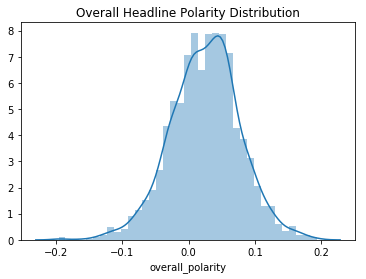

In [8]:
sns.distplot(combined['overall_polarity'])
plt.title("Overall Headline Polarity Distribution")
plt.savefig('visualizations/distplots/overall_headline_polarity.png')

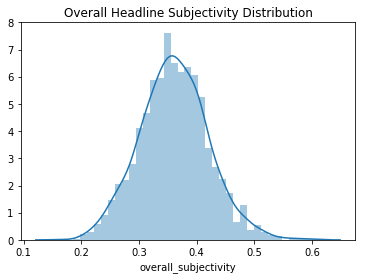

In [9]:
sns.distplot(combined['overall_subjectivity'])
plt.title("Overall Headline Subjectivity Distribution")
plt.savefig('visualizations/distplots/overall_headline_subjectivity.png')

Fascinating! It appears that, for the most part, headlines generally skew positive on a day to day basis, again something I wouldn't have expected due to the generally bad reputation the news gets for focusing on the negative! Of course this polarity plot is fairly narrow, only spanning a range of -0.2 to 0.2, indicating to me that, for the most part, headlines don't have much of a positive or negative bias when you look at the big picture. As for subjectivity, it looks like news headlines are, on average, mildly subjective on when you look at the big picture, though I'm happy to see that the vast majority of this plot stays below the 0.5 mark indicating to me that, for the most part, headlines focus more on fact than opinion which I believe should be the case.

With that I'm done with the sentiment analysis aspect and it is time to move on to the clustering aspect of the model. Here I will cluster the headlines to get an idea about general categories that the headlines fit into. In order to do this effectively, I first need to do a couple of things, first of which is convert my text data to numeric data as this is what the k-means clustering algorithm requires, let's knock that out using the `TfidfVectorizer` function, which stands for a Term Frequency - Inverse Document Frequency Vectorizer, which in this case will essentially assign numeric values to the words in each headline based on the frequency of the words both within headlines (higher score) and accross documents (lower score): 

In [10]:
# https://pythonprogramminglanguage.com/kmeans-text-clustering/
vectorizer = TfidfVectorizer(stop_words='english')
headlines_vect = vectorizer.fit_transform(headlines['News_cleaned'].astype(str))
headlines_vect

<73608x41210 sparse matrix of type '<class 'numpy.float64'>'
	with 777349 stored elements in Compressed Sparse Row format>

Awesome, now that this vector is in place the next thing I need to accomplish before creating my final clusering algorithm is determine the number of clusters I should use. There are a few ways to accomplish this, two of which are the Elbow method and the Silhouette method. I've tried both and found that the Silhouette method is much to slow to be practical, so I'm going to stick with the Elbow method. In the Elbow method, I will run the k-means algorithm with my data for a range of number of clusters and see at which point increasing clusters doesn't do much for decreasing the sum of squares distances. Let's do that now:

Attempting with 1 clusters...
1 clusters done in 9 seconds, or 0.15 minutes. 
Total elapsed time 0.15 minutes.
Attempting with 2 clusters...
2 clusters done in 101 seconds, or 1.6833333333333333 minutes. 
Total elapsed time 1.8333333333333333 minutes.
Attempting with 3 clusters...
3 clusters done in 80 seconds, or 1.3333333333333333 minutes. 
Total elapsed time 3.183333333333333 minutes.
Attempting with 4 clusters...
4 clusters done in 130 seconds, or 2.1666666666666665 minutes. 
Total elapsed time 5.35 minutes.
Attempting with 5 clusters...
5 clusters done in 137 seconds, or 2.283333333333333 minutes. 
Total elapsed time 7.633333333333334 minutes.
Attempting with 6 clusters...
6 clusters done in 130 seconds, or 2.1666666666666665 minutes. 
Total elapsed time 9.816666666666666 minutes.
Attempting with 7 clusters...
7 clusters done in 197 seconds, or 3.283333333333333 minutes. 
Total elapsed time 13.1 minutes.
Attempting with 8 clusters...
8 clusters done in 181 seconds, or 3.0166666666

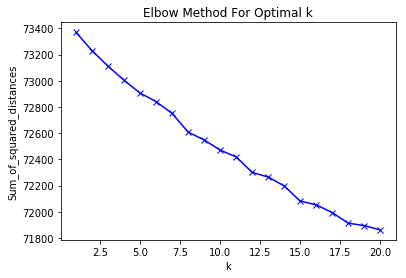

In [11]:
# This takes a bit, so getting the start time to track execution times
start = datetime.now()
# create list for storing sum of squares distances
ssq_dists = list()
# create range of number of clusters to attempt, here 1 through 20
ks = range(1,21)
# set last run to start time to facilitate tracking length of exection
lastrun = start
# create runtimes dict for keeping track of run times by number of clusters
runtimes = dict()
# for each number of clusters to attempt
for k in ks:
    print("Attempting with " + str(k) + " clusters...")
    # run k-means with number of clusters, specifying random state for reproducibility
    km = KMeans(n_clusters=k, random_state=101)
    # Fit the data to the clusterming model created
    km = km.fit(headlines_vect)
    # get current time
    cur = datetime.now()
    # get total elapsed time so far
    elapsed = cur - start
    # get length of current run
    cur_run = cur - lastrun
    # add current run runtime to runtimes dict at key of current cluster count
    runtimes[k] = cur_run
    # set last run end time to current time
    lastrun = datetime.now()
    # print to track progress of loop
    print(str(k) + " clusters done in " + str(cur_run.seconds) + " seconds, or " + str(cur_run.seconds / 60) 
          + " minutes. \nTotal elapsed time " + str(elapsed.seconds / 60) + " minutes.")
    # add sum of squares distance for current model to sum of squares list for plotting after loop
    ssq_dists.append(km.inertia_)

# calculate total runtime of above loop
total_time = datetime.now() - start
# notify that loop is done
print("Done! Execution took " + str(total_time) + ". Building elbow plot...")
# generate and display plot of sum of square distances by number of clusters
plt.plot(ks, ssq_dists, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Wow that took much longer than I expected! Unfortunately there is not as obvious an elbow in the plot as I would like to see. Even so, there are a couple points where the slope clearly changes. The first of these seem to occur at 5 and 8 clusters, and while I’m used to picking the lower number of clusters, I can’t help but notice that the slope from 7 to 8 clusters is quite steep while the slope seems to be more consistently smaller after 8 clusters, so I will stick with 8 clusters for my final clustering model. Let's generate that clustering model now:

In [12]:
cluster_model = KMeans(n_clusters=8, random_state=101).fit(headlines_vect)
cluster_model.labels_

array([4, 4, 4, ..., 4, 4, 4], dtype=int32)

Awesome! Now lets create a new column in the headlines dataset that indicates the cluster that each headline belongs to:

In [13]:
headlines['cluster'] = cluster_model.labels_
headlines.head()

,Date,News,tokenized,News_cleaned,cleaned_tokenized,polarity,subjectivity,cluster
0,2016-07-01,A 117 year old woman in Mexico City finally re...,"['A', '117', 'year', 'old', 'woman', 'in', 'Me...",year old woman mexico city finally received bi...,"['year', 'old', 'woman', 'mexico', 'city', 'fi...",-0.025000,0.325000,4
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,"['IMF', 'chief', 'backs', 'Athens', 'as', 'per...",imf chief backs athens permanent olympic host,"['imf', 'chief', 'backs', 'athens', 'permanent...",0.000000,0.000000,4
2,2016-07-01,The president of France says if Brexit won so ...,"['The', 'president', 'of', 'France', 'says', '...",president france says brexit donald trump,"['president', 'france', 'says', 'brexit', 'don...",0.000000,0.000000,4
3,2016-07-01,British Man Who Must Give Police 24 Hours Noti...,"['British', 'Man', 'Who', 'Must', 'Give', 'Pol...",british man must give police hours notice sex ...,"['british', 'man', 'must', 'give', 'police', '...",0.111111,0.388889,4
4,2016-07-01,100 Nobel laureates urge Greenpeace to stop op...,"['100', 'Nobel', 'laureates', 'urge', 'Greenpe...",nobel laureates urge greenpeace stop opposing ...,"['nobel', 'laureates', 'urge', 'greenpeace', '...",0.000000,0.000000,4


Alright now that this is in place I'm interested to see if these clusters really do have some sort of categorical meaning behind them. To determine this, I'll create Word Clouds by cluster and see if I can recognize some patterns regarding cluster category:

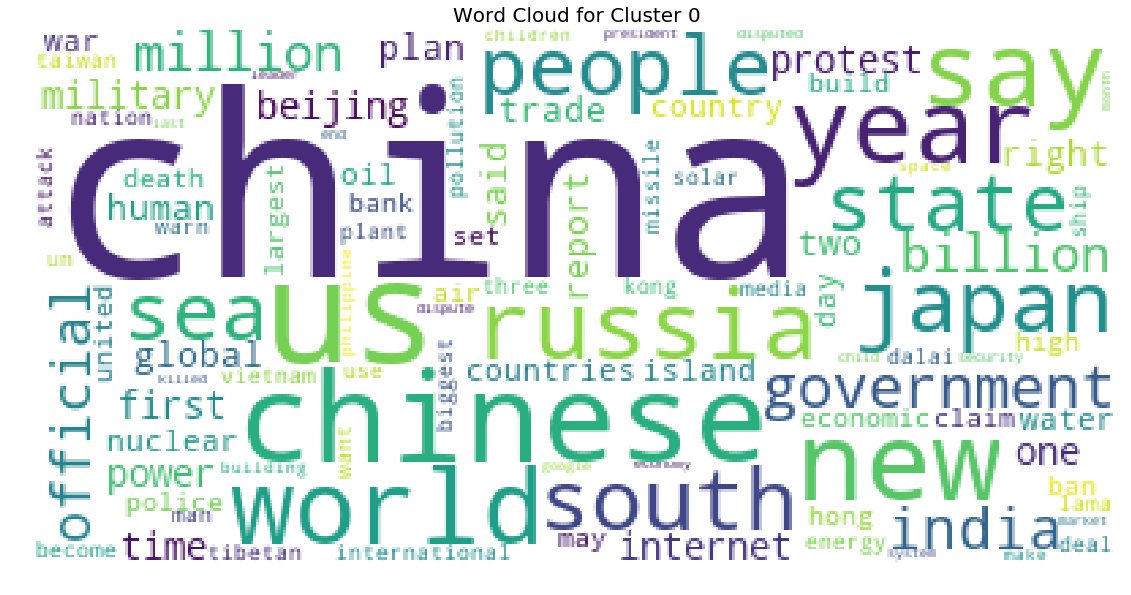

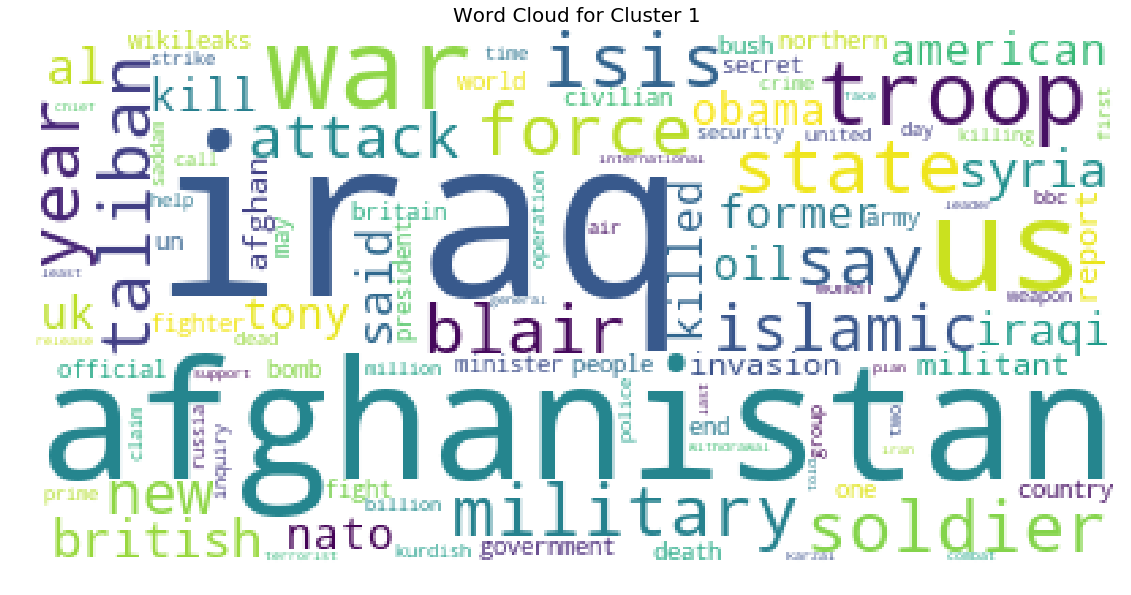

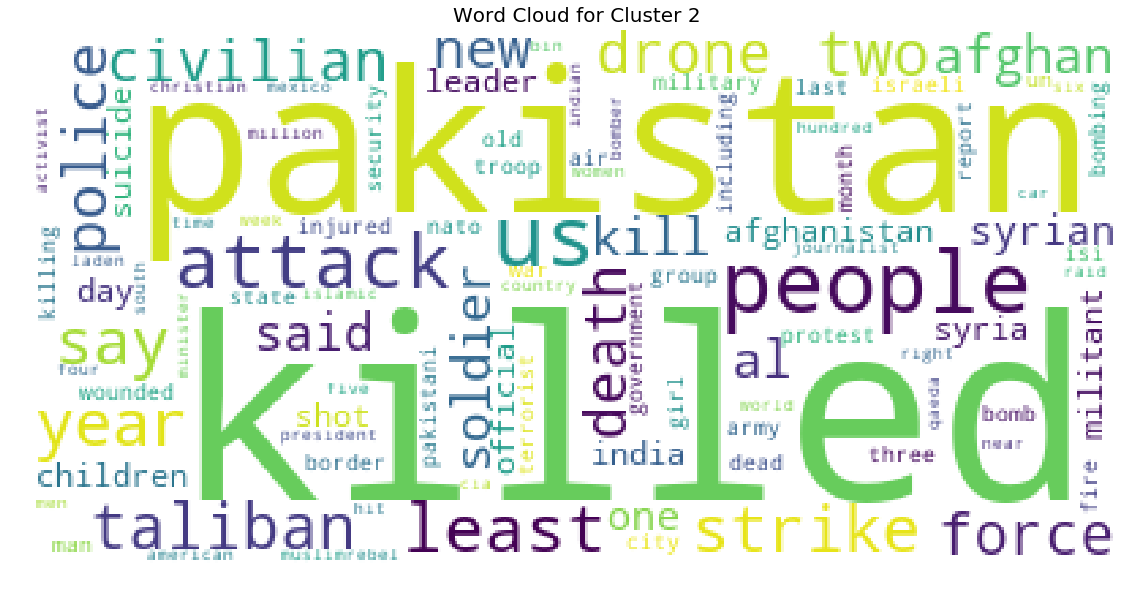

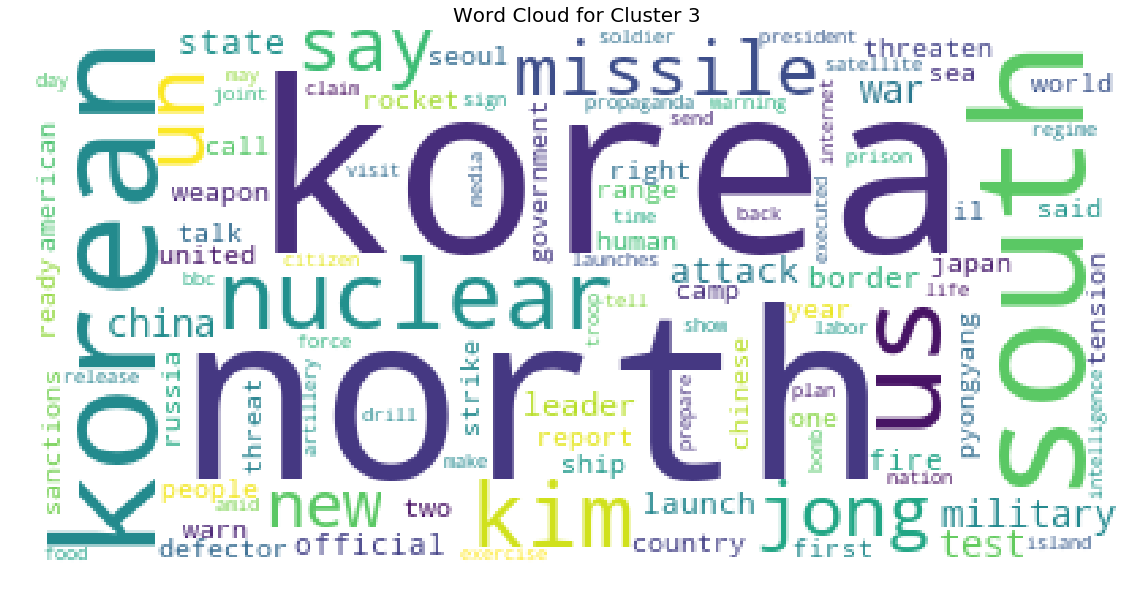

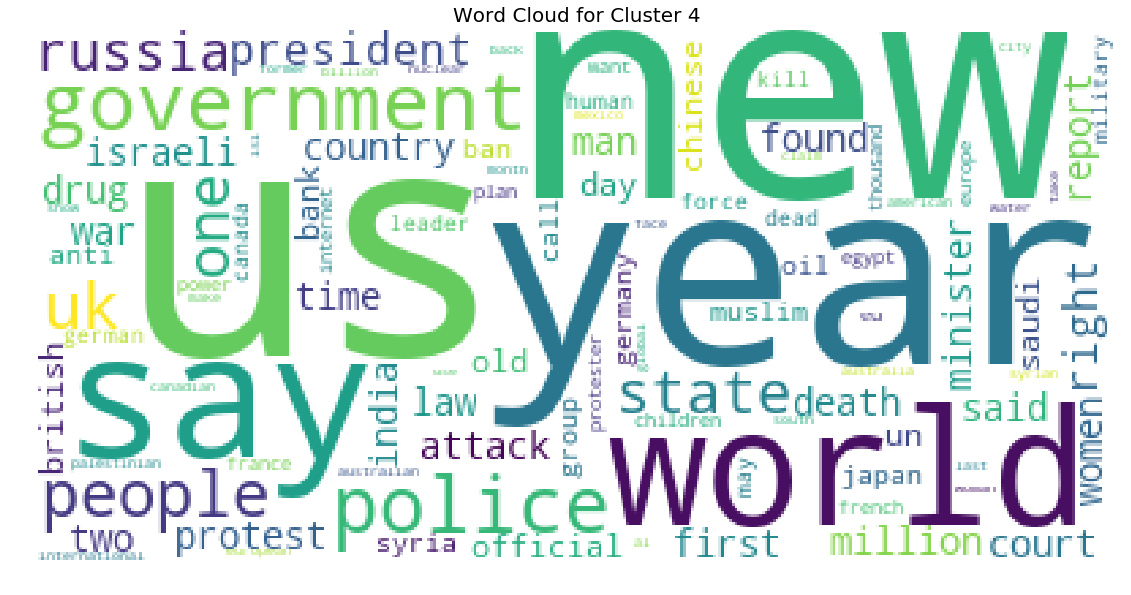

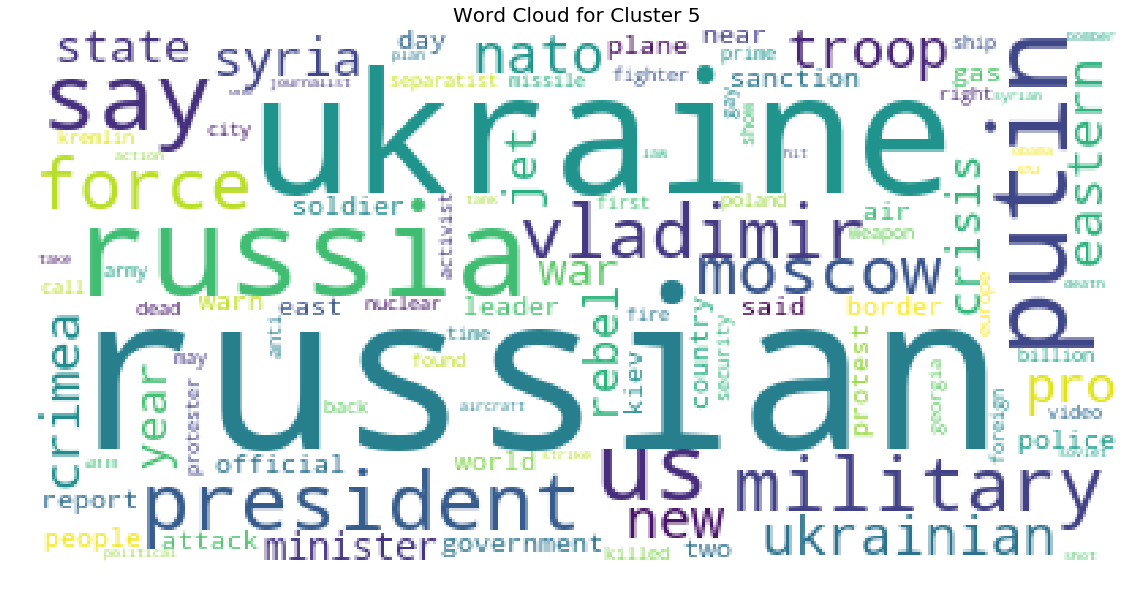

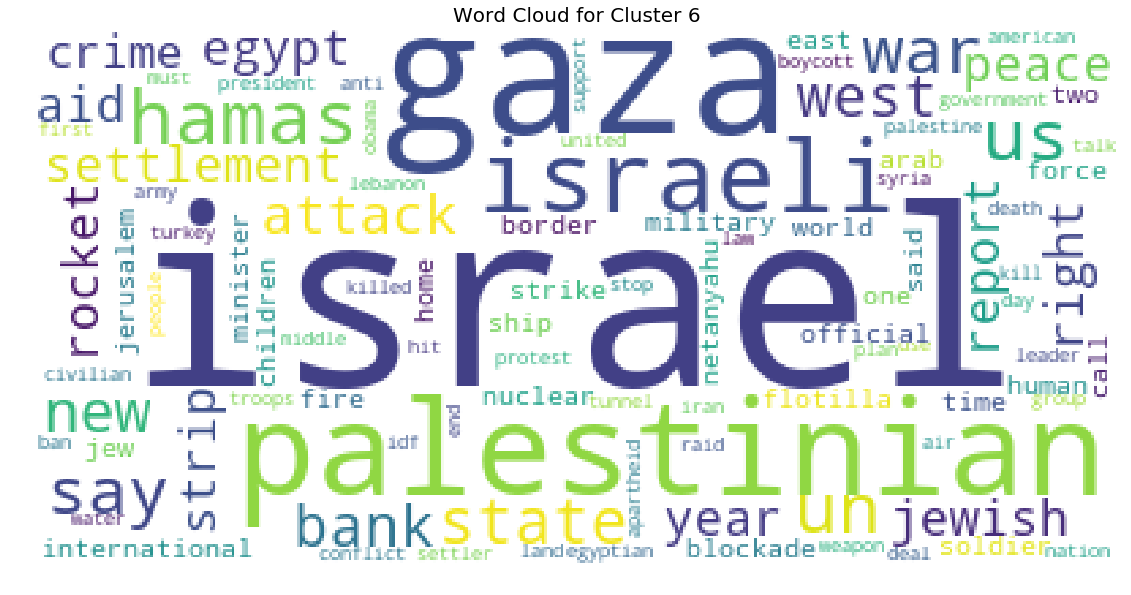

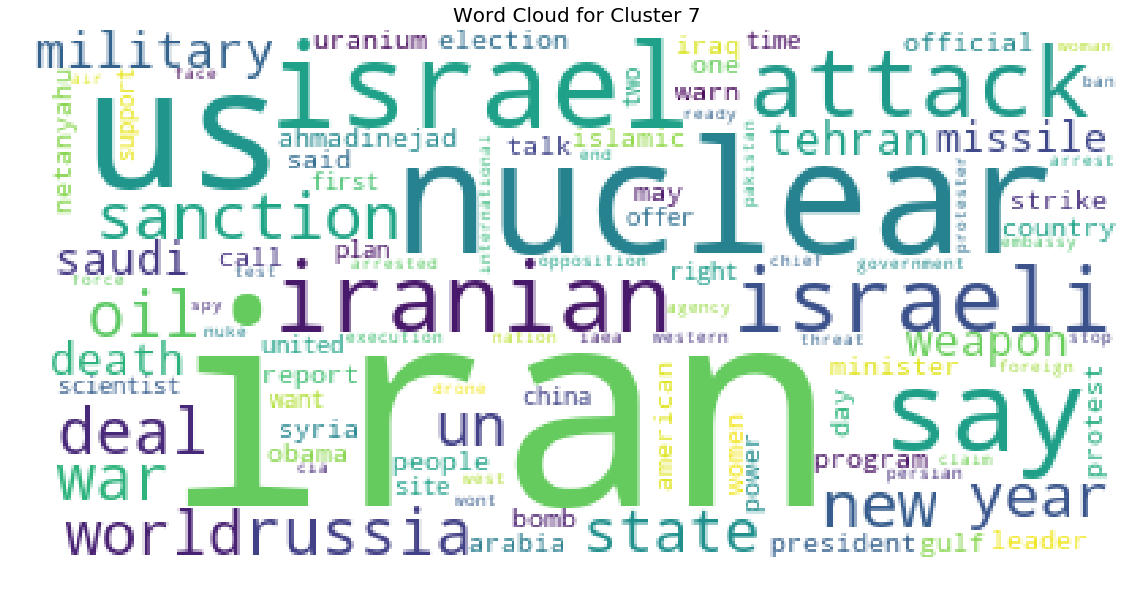

In [14]:
def gen_wordcloud(col, count):
    # initialize temporary string
    temp = ""
    # loop through each headline in the column
    for line in col:
        if str(line) == "nan":
            continue
        # append lines to temporary string
        temp += line + " "
    # generate word cloud with a max of 100 words using the temporary string
    wc = WordCloud(max_words = 100, background_color = "white", repeat = False, collocations = False).generate(temp)
    # write out to file for vizualizations folder
    wc.to_file('visualizations/wordclouds/cluster{0}_wordcloud.png'.format(str(count)))
    plt.figure(figsize = (20, 10))
    plt.imshow(wc)
    plt.axis('off')
    plt.title('Word Cloud for Cluster ' + str(i), fontdict = {
        'fontsize': 20,
        'fontweight' : 5,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'
    })
    plt.show()

for i in sorted(headlines['cluster'].unique()):
    gen_wordcloud(headlines[headlines['cluster'] == i]['News_cleaned'], i)

Alright so it does look like most of these have a general pattern: 
* In cluster 0, clearly China and Chinese are mentioned a lot and so are some other countries in this region of the world, like Russia, India, and Japan while the US is also thrown in there. This tells me that cluster 0 is primarily related to China and it's relationships in the world. 
* In cluster 1, Iraq and Afghanistan are mentioned the most along with words like war, US, Talian, Syria, soldier, and military. This tells me that cluster 1 is primarily related to war in the middle east
* As for cluster 2, the most common words are killed and Pakistan while there is also mention of other words like civilian, Taliban, strike, death, and people. To me, this is somewhat also related to conflict in the middle east like cluster 1 but more so related to death and injury rather than war itself
* Cluster 3 is clearly contains Korea more than any other word with North and South following near behind along with other words like Korean, Kim, Jong, Un, and Nuclear among others. Clearly this cluster primarily refers to the Koreas and the tension and conflict going on in that region.
* Now looking at cluster 4 I really don't see that much of a clear pattern amongst the words and many of the ones present here remind me of the common words in the overall corpus of headlines. This tells me that this is likely the miscellaneous cluster where things that didn't fit well into other clusters wound up. 
* For cluster 5 the most common word is Russian followed by words like Ukraine, Vladimir, Putin, Russia, and Moscow, clearly indicating to me that this cluster primarily holds headlines related to Russia, especially in regards to the Russia-Ukraine conflict
* The most common word in cluster 6 is obviously Isreal followed by words like Gaza, Palestinian, Isreali, settlement, state, and Hamas, which indicates to me that this cluster contains headlines primarily focused on the Palistinian-Isreali conflict over the Gaza strip
* Finally, cluster 7 has Iran as the most common word followed by Nuclear, US, attack, sanction, deal, and Isreal. This indicates to me that this cluster contains primarily headlines that pertain to the Iranian Nuclear Deal and Iran in general. 

Very cool stuff. Now that that's done and I've verified that these clusters do actually hold some amount of meaning, I need to add this `cluster` column to the combined dataset somehow. I'm not entirely sure the most optimal way to go about this as applying the TfidfVectorizer function to each individual `Top#` column will result in different values for the same headline compared with this application to all the headlines, which would ultimately result in misscalssification of headlines into the clusters if I tried a simple `model.predict` on each headline. What I'll do instead is loop through each row of the combined dataset, grab the date, and create a small, temporary, dataframe from the headlines dataset that matches the date of the current combined dataset row. I can then loop through each headline in the combined dataset row and match this to a headline in the headlines dataset, grabbing the corresponding cluster label and adding that to the combined dataset. Let's do this now:

In [15]:
for i in range(1,26):
    combined["Top" + str(i) + "_cluster"] = np.nan
cols = [col for col in list(combined.columns) if col.startswith('Top') and col.endswith('_cleaned')]
for i in tqdm_notebook(range(combined.shape[0]), desc="Combined Dataset Rows Processed"):
    date = combined.iloc[i,:]['Date']
    temp = headlines[headlines['Date'] == date]
    for col in cols:
        for j in range(temp.shape[0]):
            if combined.iloc[i,:][col] == temp.iloc[j,:]['News_cleaned']:
                prefix = col.split('_')[0]
                combined[prefix + "_cluster"][i] = list(temp['cluster'])[j]
combined.head()

#combined = pd.merge(combined, headlines[[x for x in list(headlines.columns) if x.endswith("cluster") or x == "Date"]], how = 'right', left_on = 'Date', right_on = 'Date')

/Users/dsciacca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16_cluster,Top17_cluster,Top18_cluster,Top19_cluster,Top20_cluster,Top21_cluster,Top22_cluster,Top23_cluster,Top24_cluster,Top25_cluster
0,2008-08-08,0,Georgia downs two Russian warplanes as countri...,BREAKING Musharraf to be impeached,Russia Today Columns of troops roll into South...,Russian tanks are moving towards the capital o...,Afghan children raped with impunity UN officia...,150 Russian tanks have entered South Ossetia w...,Breaking Georgia invades South Ossetia Russia ...,The enemy combatent trials are nothing but a s...,...,4.0,4.0,6.0,7.0,1.0,7.0,4.0,4.0,4.0,4.0
1,2008-08-11,1,Why wont America and Nato help us If they wont...,Bush puts foot down on Georgian conflict,Jewish Georgian minister Thanks to Israeli tra...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in SOssetia blames ...,...,6.0,5.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0
2,2008-08-12,0,Remember that adorable 9 year old who sang at ...,Russia ends Georgia operation,If we had no sexual harassment we would have n...,Al Qaeda is losing support in Iraq because of ...,Ceasefire in Georgia Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO 1...,Stratfor The Russo Georgian War and the Balanc...,Im Trying to Get a Sense of This Whole Georgia...,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0
3,2008-08-13,0,US refuses Israel weapons to attack Iran report,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,Britain\s policy of being tough on drugs is po...,Body of 14 year old found in trunk Latest rans...,China has moved 10 million quake survivors int...,Bush announces Operation Get All Up In Russias...,Russian forces sink Georgian ships,...,4.0,4.0,4.0,5.0,7.0,4.0,5.0,4.0,4.0,4.0
4,2008-08-14,1,All the experts admit that we should legalise ...,War in South Osetia 89 pictures made by a Ru...,Swedish wrestler Ara Abrahamian throws away me...,Russia exaggerated the death toll in South Oss...,Missile That Killed 9 Inside Pakistan May Have...,Rushdie Condemns Random Houses Refusal to Publ...,Poland and US agree to missle defense deal Int...,Will the Russians conquer Tblisi Bet on it no ...,...,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0


That definitely took a while. I'd bet there is a more optimal way to do this, but for the time being this suffices for my needs. Now, let's examine the value_counts from each of these columns to make sure no NaN values persisted to confirm that all `Top#` headlines were matched with a respective column:

In [16]:
cols = [col for col in list(combined.columns) if col.startswith("Top") and col.endswith("_cluster")]
for col in cols:
    print(combined[col].value_counts(dropna = False))

4.0    1694
6.0      54
0.0      46
3.0      46
5.0      46
2.0      44
1.0      30
7.0      29
Name: Top1_cluster, dtype: int64
4.0    1663
6.0      77
0.0      49
5.0      48
3.0      46
2.0      46
1.0      36
7.0      24
Name: Top2_cluster, dtype: int64
4.0    1640
6.0      79
3.0      58
0.0      51
5.0      51
2.0      47
7.0      39
1.0      24
Name: Top3_cluster, dtype: int64
4.0    1637
6.0      83
3.0      56
2.0      55
0.0      52
5.0      46
1.0      32
7.0      28
Name: Top4_cluster, dtype: int64
4.0    1612
6.0      80
2.0      70
5.0      66
3.0      50
7.0      40
0.0      40
1.0      31
Name: Top5_cluster, dtype: int64
4.0    1587
6.0      76
0.0      64
3.0      60
2.0      60
5.0      60
7.0      49
1.0      33
Name: Top6_cluster, dtype: int64
4.0    1602
6.0      88
0.0      69
5.0      56
2.0      56
3.0      49
7.0      35
1.0      34
Name: Top7_cluster, dtype: int64
4.0    1591
6.0      80
5.0      67
2.0      64
0.0      62
1.0      47
3.0      41
7.0      37
N

So it looks like there are a few NaN values in the `Top#_cluster` columns, but there are only 8 NaN values in all of these 25 columns, so it's not really enough to make it worth the effort of finding the corresponding headlines and matching it to a cluster. Instead, I will simply replace all instances of NaN values with the catch all cluster, cluster 4:

In [17]:
cols = [c for c in list(combined.columns) if 'cluster' in c]
temp = combined[cols]
temp.fillna(4, inplace = True)
combined[cols] = temp

/Users/dsciacca/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Great, now let's write this dataframe out so that we don't need to perform these analyses again everytime this notebook is restarted:

In [18]:
headlines.to_csv('data/cleaned/processed/headlines.csv', index = False)
combined.to_csv('data/cleaned/processed/combined.csv', index = False)

In [19]:
DJIA = pd.read_csv('data/cleaned/DJIA.csv')
combined = pd.read_csv('data/cleaned/processed/combined.csv')
headlines = pd.read_csv('data/cleaned/processed/headlines.csv')


print("headlines: ")
display(headlines.head())
print("DJIA: ")
display(DJIA.head())
print("combined_df: ")
display(combined.head())

headlines: 


,Date,News,tokenized,News_cleaned,cleaned_tokenized,polarity,subjectivity,cluster
0,2016-07-01,A 117 year old woman in Mexico City finally re...,"['A', '117', 'year', 'old', 'woman', 'in', 'Me...",year old woman mexico city finally received bi...,"['year', 'old', 'woman', 'mexico', 'city', 'fi...",-0.025000,0.325000,4
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,"['IMF', 'chief', 'backs', 'Athens', 'as', 'per...",imf chief backs athens permanent olympic host,"['imf', 'chief', 'backs', 'athens', 'permanent...",0.000000,0.000000,4
2,2016-07-01,The president of France says if Brexit won so ...,"['The', 'president', 'of', 'France', 'says', '...",president france says brexit donald trump,"['president', 'france', 'says', 'brexit', 'don...",0.000000,0.000000,4
3,2016-07-01,British Man Who Must Give Police 24 Hours Noti...,"['British', 'Man', 'Who', 'Must', 'Give', 'Pol...",british man must give police hours notice sex ...,"['british', 'man', 'must', 'give', 'police', '...",0.111111,0.388889,4
4,2016-07-01,100 Nobel laureates urge Greenpeace to stop op...,"['100', 'Nobel', 'laureates', 'urge', 'Greenpe...",nobel laureates urge greenpeace stop opposing ...,"['nobel', 'laureates', 'urge', 'greenpeace', '...",0.000000,0.000000,4


DJIA: 


,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


combined_df: 


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16_cluster,Top17_cluster,Top18_cluster,Top19_cluster,Top20_cluster,Top21_cluster,Top22_cluster,Top23_cluster,Top24_cluster,Top25_cluster
0,2008-08-08,0,Georgia downs two Russian warplanes as countri...,BREAKING Musharraf to be impeached,Russia Today Columns of troops roll into South...,Russian tanks are moving towards the capital o...,Afghan children raped with impunity UN officia...,150 Russian tanks have entered South Ossetia w...,Breaking Georgia invades South Ossetia Russia ...,The enemy combatent trials are nothing but a s...,...,4.0,4.0,6.0,7.0,1.0,7.0,4.0,4.0,4.0,4.0
1,2008-08-11,1,Why wont America and Nato help us If they wont...,Bush puts foot down on Georgian conflict,Jewish Georgian minister Thanks to Israeli tra...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in SOssetia blames ...,...,6.0,5.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0
2,2008-08-12,0,Remember that adorable 9 year old who sang at ...,Russia ends Georgia operation,If we had no sexual harassment we would have n...,Al Qaeda is losing support in Iraq because of ...,Ceasefire in Georgia Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO 1...,Stratfor The Russo Georgian War and the Balanc...,Im Trying to Get a Sense of This Whole Georgia...,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0
3,2008-08-13,0,US refuses Israel weapons to attack Iran report,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,Britain\s policy of being tough on drugs is po...,Body of 14 year old found in trunk Latest rans...,China has moved 10 million quake survivors int...,Bush announces Operation Get All Up In Russias...,Russian forces sink Georgian ships,...,4.0,4.0,4.0,5.0,7.0,4.0,5.0,4.0,4.0,4.0
4,2008-08-14,1,All the experts admit that we should legalise ...,War in South Osetia 89 pictures made by a Ru...,Swedish wrestler Ara Abrahamian throws away me...,Russia exaggerated the death toll in South Oss...,Missile That Killed 9 Inside Pakistan May Have...,Rushdie Condemns Random Houses Refusal to Publ...,Poland and US agree to missle defense deal Int...,Will the Russians conquer Tblisi Bet on it no ...,...,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0


Now the moment we've all been waiting for: it is time to start building my final models in which I will try to predict whether stocks will rise or fall on a day based on details relating to the top 25 news headlines from that day as well as periods of time leading up. I say models here because I want to try a few different approaches. In one approach, I want to see how headline sentiment as well as cluster might be used in the same model to predict stock rise and fall. In another approach, I'd like to try building a few separate models, such as one that uses sentiment of headlines, another that uses the clusters of the headlines, and another that uses the stocks timeseries data to all individually predict market rise or fall and then poll each of these disperate models to get their votes on whether or not stocks will rise or fall that day in hopes of improving overall accuracy. Since market rise is a binary variable, I will use binary prediction techniques, and the two algorithms I want to focus on here are logistic regression and random forest. I will start with logistic regression and then move on to using a random forest down the line. 

Starting with logistic regression, the first thing I want to do is check out whether or not my outcome variables are about balanced. I'll do this first visually and if there seems to be a misbalance here then I'll dig deeper:

### Logistic Regression process link: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

### When get to random forest, see this link: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652



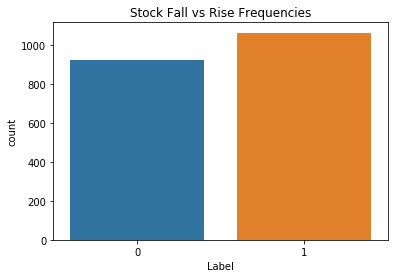

In [20]:
sns.countplot(x = 'Label', data = combined)
plt.title("Stock Fall vs Rise Frequencies")
plt.savefig('visualizations/countplots/stock_rise_fall.png')

From the plot above, it doesn't appear that the classes are significantly different by any means, but lets check the ratio just to be sure:

In [21]:
up = len(combined[combined['Label'] == 1])
down = len(combined[combined['Label'] == 0])
print("Percentage of up days is " + str(up / combined.shape[0]))
print("Percentage of down days is " + str(down / combined.shape[0]))

Percentage of up days is 0.5354449472096531
Percentage of down days is 0.4645550527903469


Awesome there isn't really that huge of a difference between these occurances, so I don't see a need to balance the classes here at all when building my models. Let's now isolate the predictor and outcome variables into a single dataset and then split these into training and testing sets:

In [22]:
# create temp list of columns containing just the label, polarity, subjectivity, and cluster columns
temp = [x for x in list(combined.columns) if x == "Label" or x.endswith('ity') or (x.startswith('Top') and x.endswith('cluster'))]
# subset the combined dataset to grab just the key columns
data = combined[temp]
data.head()

,Label,Top1_polarity,Top1_subjectivity,Top2_polarity,Top2_subjectivity,Top3_polarity,Top3_subjectivity,Top4_polarity,Top4_subjectivity,Top5_polarity,...,Top16_cluster,Top17_cluster,Top18_cluster,Top19_cluster,Top20_cluster,Top21_cluster,Top22_cluster,Top23_cluster,Top24_cluster,Top25_cluster
0,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.050000,0.200000,-0.307143,...,4.0,4.0,6.0,7.0,1.0,7.0,4.0,4.0,4.0,4.0
1,1,0.000000,0.000000,-0.155556,0.288889,0.10,0.100000,0.000000,0.000000,0.000000,...,6.0,5.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0
2,0,0.033333,0.733333,0.000000,0.000000,-0.25,0.833333,-0.875000,1.000000,0.000000,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0
3,0,0.000000,0.000000,0.000000,0.000000,-0.20,0.000000,-0.212963,0.444444,0.175000,...,4.0,4.0,4.0,5.0,7.0,4.0,5.0,4.0,4.0,4.0
4,1,0.000000,0.000000,0.000000,0.000000,0.40,0.400000,-0.233333,0.666667,-0.200000,...,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0


Perfect, now lets split this into training and testing sets:

In [23]:
# get all columns that aren't the Label column for x
x = data[[c for c in list(data.columns) if c != "Label"]]
# Split data into training and testing sets using a 70/30 split
x_train, x_test, y_train, y_test = train_test_split(x, data['Label'], test_size = 0.3, random_state = 101)

Now that I've got my training and testing sets, lets give the logistic regression a go. First I'll try it with all of my predictor columns and see what kind of outcomes this gives me and depending on how this goes I might try to apply a feature selection algorithm if it doesn't work out very well:

In [24]:
# initialize logistic regression model
lr = LogisticRegression()
# fit model to training data
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now that the model has been fit to the training set, let's see how this performs on the testing set in terms of accuracy:

In [25]:
# use model to predict the testing set
y_pred = lr.predict(x_test)
# output the accuracy of the testing set
print('Accuracy of logistic regression classifier on test set: ' + str(lr.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.5008375209380235


So the accuracy is just 50%, which essentially means that this model is no better than a guess, very dissapointing. Let's check out the confusion matrix before trying to perform some feature selection algorithms:

In [26]:
# create confusion matrix and print it
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[112 155]
 [143 187]]


Wow so it looks like this model correctly predicted 112 true down days but misclassified 155 down days as up days while the model misclassified 143 down days as up days but correctly classified 187 up days as up days. this is some pretty awful performance, so let's see if performing feature selection on the columns might help. To do this, I'll use the RFE or Recursive Feature Elimination algorithm from sklearn to cut the number of predictors in half:

In [27]:
# initialize new logistic regression model
lr = LogisticRegression()
# Perform recursive feature elimination to get half of the original number of features
rfe = RFE(lr, int(x_train.shape[1] / 2))
# fit the RFE model to the training data
rfe = rfe.fit(x_train, y_train.values.ravel())
# initialize list to hold columns to keep
keep_cols = list()
# populate keep_cols with those that the recursive feature elimination stated to keep
for i in range(len(rfe.support_)):
    if rfe.support_[i]:
        keep_cols.append(list(x_train.columns)[i])
keep_cols

['Top1_polarity',
 'Top1_subjectivity',
 'Top2_polarity',
 'Top2_subjectivity',
 'Top3_polarity',
 'Top3_subjectivity',
 'Top6_subjectivity',
 'Top8_polarity',
 'Top8_subjectivity',
 'Top9_polarity',
 'Top9_subjectivity',
 'Top10_polarity',
 'Top10_subjectivity',
 'Top11_subjectivity',
 'Top12_subjectivity',
 'Top13_polarity',
 'Top14_polarity',
 'Top14_subjectivity',
 'Top15_subjectivity',
 'Top16_subjectivity',
 'Top18_polarity',
 'Top18_subjectivity',
 'Top19_polarity',
 'Top19_subjectivity',
 'Top20_polarity',
 'Top21_polarity',
 'Top21_subjectivity',
 'Top22_polarity',
 'Top22_subjectivity',
 'Top23_polarity',
 'Top23_subjectivity',
 'Top25_polarity',
 'Top25_subjectivity',
 'overall_polarity',
 'Top4_cluster',
 'Top14_cluster',
 'Top15_cluster',
 'Top17_cluster']

Very interesting, from the keep_cols list above it is quite obvious to me that headline sentiment plays a much larger role in predicting stock performance than the content of the headlines as only 4 of the 25 cluster columns were selected to keep around. Lets restrict the datasets down to just these features, fit a model using these features, and then check out the details of this model before moving on:

In [28]:
# append Label column to keep_cols so don't lose the label column when subsetting
keep_cols.append('Label')
# create new dataset of just the columns to keep
data2 = data[keep_cols]
# grab predictor columns from new dataset
x2 = data2[[c for c in list(data2.columns) if c != "Label"]]
# split new dataset into training and testing sets usint 70/30 split
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, data2['Label'], test_size = 0.3, random_state = 101)

# train logistic regression model on training sets
logit_model = sm.Logit(y2_train, x2_train)
# get results of the model
result = logit_model.fit()
# output results of the model
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.666475
         Iterations 5
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.036     
Dependent Variable:  Label            AIC:              1931.4673 
Date:                2019-08-20 08:41 BIC:              2130.5302 
No. Observations:    1392             Log-Likelihood:   -927.73   
Df Model:            37               LL-Null:          -962.67   
Df Residuals:        1354             LLR p-value:      0.00086980
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      5.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Top1_polarity       0.1325   0.2746  0.4823 0.6296 -0.4058  0.6707
Top1_subjectivity  -0.2702   0.2022 -1.3363 0.1815 -0

Unfortunately the output above doesn't give me much hope; a vast majority of the p-values are not significant in this model, which makes me think this isn't going to improve my outcomes very much, if at all. Either way it's worth trying, so let's do that now:

In [29]:
# initialize new LR model
lr = LogisticRegression()
# fit model on new training set
lr.fit(x2_train, y2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
# predict labels for testing set
y2_pred = lr.predict(x2_test)
# output accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(x2_test, y2_test)))

Accuracy of logistic regression classifier on test set: 0.51


In [31]:
# Create and print confusion matrix
cm = confusion_matrix(y2_test, y2_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[111 156]
 [135 195]]


According to the accuracy above, it seems that I ever so slightly improved my model accuracy; however, the confusion matrix shows that this model actually got _worse_ at predicting down days, though it did get slightly better at predicting up days. Either way I don't think logistic regression is working out. I will likely circle back down the line and try a few more things in terms of tweaking this model, like performing more strict feature selection. For now, though, I want to move on to building a random forest model to see if this might be more promising.

Since I have already split my data into training and testing sets, I can go ahead and dive right into building my model. I will use the `RandomForestClassifier` from sklearn for this:

In [32]:
# initialize RandomForestClassifier model
rfc = RandomForestClassifier(random_state = 101)
# fit model to the training data
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

That was easy enough, now lets have this model predict the testing set and evaluate accuracy:

In [33]:
# get label predictions on testing set
rfc_predictions = rfc.predict(x_test)
# cross validate the RandomForestClassifier model with 10 folds using the ROC AUC alogirthm to score the model
rfc_cv_score = cross_val_score(rfc, x, data['Label'], cv=10, scoring='roc_auc')

In [34]:
# output confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test, rfc_predictions))

# output classification report to get idea of precision, recall, and support
print("\nClassification Report")
print(classification_report(y_test, rfc_predictions))

# output all AUC scores
print("\nAll AUC Scores")
print(rfc_cv_score)

# Output mean AUC score to get overall performance
print("\nMean AUC Score")
print(rfc_cv_score.mean())

Confusion Matrix
[[144 123]
 [180 150]]

Classification Report
             precision    recall  f1-score   support

          0       0.44      0.54      0.49       267
          1       0.55      0.45      0.50       330

avg / total       0.50      0.49      0.49       597


All AUC Scores
[0.48829263 0.44312129 0.51075269 0.50934579 0.4960382  0.47902994
 0.52189295 0.47364643 0.40171247 0.53112182]

Mean AUC Score
0.4854954216184324


Alright well it looks like the Random Forest model did about as well as the logistic regression model. This is somewhat disappointing because I was hopeful that a Random Forest model might be more successful than LR. Let's see if optimizations on this model might help improve the AUC score. The optimization I want to try is hyperparameter tuning, lets give this a go:

In [35]:
# number of trees in random forest, using 10 values from a range of 200 to 2000
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# number of features at every split, options include auto, sqrt (same as auto), log2, None and numeric values
max_features = ['auto', 'log2', None]

# minimum number of samples before node split
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree, False uses all samples for each tree
bootstrap = [True, False]

# max depth of the tree, using 11 values with range of 100 to 500 
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)

# create random grid of hyperparameters to pass into RandomizedSearchCV
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'max_depth': max_depth
}
# Random search of parameters using RandomForestClassifier as estimator, 200 iterations, with 5 folds in the
# cross validation. Setting random state for reproducibility and n_jobs to -1 for parallelization
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 200, cv = 5, 
                                verbose = 2, random_state = 101, n_jobs = -1)
# Fit the model on the training data
rfc_random.fit(x_train, y_train)
# print results of the best parameters determined by the algorithm
print("\n\nBest parameters determined by Randomized Search Cross Validator: " + str(rfc_random.best_params_))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=True 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=True 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=True 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=True, total=   2.9s
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=True, total=   2.8s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=340, bootstra

[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=180, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=180, bootstrap=True, total=   1.1s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=180, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=340, bootstrap=False, total= 1.6min
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=180, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=300, bootstrap=False, total=  12.8s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=180, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=180, bootstrap=False, total=  13.3s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=180, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=180, bootstrap=False, total=  13.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=340, bootstrap=False 
[CV]  

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=300, bootstrap=True, total=   1.3s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=None, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=  15.0s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=None, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=  14.6s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=None, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=None, bootstrap=False, total= 1.0min
[CV]

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=300, bootstrap=True, total=  13.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=300, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=300, bootstrap=True, total=  13.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=260, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=300, bootstrap=True, total=  13.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=260, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=260, bootstrap=False, total=   2.8s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=260, bootstrap=False 
[CV]  n_estimators=1400,

[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=   5.1s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=   5.1s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=   5.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=None, max_depth=500, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=   5.0s
[CV] n_estimators=4

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.2min


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=None, max_depth=460, bootstrap=True, total=  35.2s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=None, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=None, bootstrap=False, total= 1.1min
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=None, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=None, bootstrap=False, total= 1.2min
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=140, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=140, bootstrap=True, total=   8.2s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=140, bootstrap=True 
[CV]  n_

[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=420, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  11.6s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=420, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  11.5s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=420, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=420, bootstrap=False, total=  14.8s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=420, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=420, bootstrap=False, total=  14.7s
[CV] n_est

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   6.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=500, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   6.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=500, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   6.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=500, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=500, bootstrap=False, total=   7.8s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=500, bootstrap=False 
[CV]  n_esti

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=300, bootstrap=False, total=   5.1s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=   3.5s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=420, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=   3.5s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=420, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=220, bootstrap=False, total=   3.4s
[CV] n_estimators=

[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=140, bootstrap=False, total=  11.6s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=140, bootstrap=False, total=  11.4s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True, total=   9.9s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True, total=  10.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=None, max_depth=340, bootstrap=False 
[CV]  n_estimators

[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=260, bootstrap=True, total=  10.0s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=260, bootstrap=True, total=   9.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False, total=  16.2s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False, total=  16.2s
[CV] n_e

[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=140, bootstrap=False, total=  17.6s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=140, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=140, bootstrap=False, total=  17.4s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=500, bootstrap=False 


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 32.7min


[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=500, bootstrap=False, total=  11.7s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=500, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=140, bootstrap=False, total=  17.5s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=500, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=140, bootstrap=False, total=  17.2s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=500, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=500, bootstrap=False, total=  11.9s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=500, bootstrap=False 
[CV]  n_esti

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=True, total=   1.2s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=260, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=None, max_depth=340, bootstrap=True, total=   6.2s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=260, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=True, total=   1.2s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=260, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=True, total=   1.2s
[CV] n_estimators=180

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True, total=   6.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True, total=   6.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=None, bootstrap=False, total= 1.7min
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=140, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=140, bootstrap=False, total=   3.9s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=140, bootstrap=False 
[CV]  n_estimators

[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=140, bootstrap=True, total=  13.5s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=None, bootstrap=False, total= 1.3min
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=True, total=  44.3s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=True, total=  44.4s
[CV] n_estimators=

[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   6.5s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=None, max_depth=260, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   6.5s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=None, max_depth=260, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   6.5s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=None, max_depth=260, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   6.4s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=None, max_depth=260, bootstrap=True 
[CV]  n_esti

[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=140, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=140, bootstrap=False, total=  14.7s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=140, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=140, bootstrap=False, total=  14.9s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=260, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=140, bootstrap=False, total=  14.8s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=260, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=140, bootstrap=False, total=  14.9s
[CV] n_estimat

[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=  10.4s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=  10.1s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=False, total=  21.4s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=220, bootstrap=False, total=  23.0s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=300, bootstrap=False 
[CV]  n_estimato

[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=300, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=380, bootstrap=False, total=  10.6s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=300, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=None, max_depth=300, bootstrap=False, total=  27.0s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=300, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=300, bootstrap=True, total=   5.0s
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=380, bootstrap=False, total=  10.3s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=300, bootstrap=True 
[CV] n_estimators=80

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=None, max_depth=380, bootstrap=False, total=  20.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=None, max_depth=380, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=None, max_depth=380, bootstrap=False, total=  23.2s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=420, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=420, bootstrap=True, total=   4.6s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=420, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=420, bootstrap=True, total=   4.7s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=420, bootstrap=True 
[CV]  n_estimators=400

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 55.4min


[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True, total=   9.9s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=460, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True, total=   9.8s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=460, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True, total=   9.9s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=460, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=300, bootstrap=True, total=   9.9s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=460, bootstrap=True 
[CV]  n_estimato

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=500, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=500, bootstrap=True, total= 1.0min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=500, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=500, bootstrap=False, total=  15.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=460, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=500, bootstrap=False, total=  15.2s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=460, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=460, bootstrap=True, total=   2.3s
[CV] n_estimator

[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=340, bootstrap=True, total=   4.2s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=340, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=340, bootstrap=True, total=   4.2s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=340, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=420, bootstrap=False, total=  10.2s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=340, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=340, bootstrap=True, total=   4.1s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=180, bootstrap=True 
[CV]  n_estimators=600, mi

[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=180, bootstrap=True, total=   7.2s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True, total=   2.5s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True, total=   2.5s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=460, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=260, bootstrap=False, total=   5.2s
[CV] n_estimators=400, min_

[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=300, bootstrap=True, total=   4.9s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=300, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=300, bootstrap=True, total=   4.9s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=220, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=300, bootstrap=True, total=   4.9s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=220, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=300, bootstrap=True, total=   4.9s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=220, bootstrap=True 
[CV]  n_estimators=600, min_

[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=100, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=380, bootstrap=False, total=  13.1s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=100, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=100, bootstrap=True, total=  56.2s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=100, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=100, bootstrap=True, total=  56.2s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=500, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=100, bootstrap=True, total=  56.4s
[CV] n_estimators=

[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=140, bootstrap=False, total=   4.9s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=140, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=140, bootstrap=False, total=   1.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=140, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=140, bootstrap=False, total=   4.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=140, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=140, bootstrap=False, total=   1.9s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=140, bootstrap=False 
[CV]  n_estimators=2

[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=False, total=   2.8s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=460, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=340, bootstrap=False, total=   2.8s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=460, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=220, bootstrap=True, total=  10.5s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=460, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=460, bootstrap=True, total=   4.3s
[CV] n_estimators=800, m

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=380, bootstrap=True, total=   7.1s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=380, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=380, bootstrap=True, total=   7.1s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=380, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=380, bootstrap=True, total=   7.1s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=220, bootstrap=False, total=   8.6s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estim

[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=340, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=100, bootstrap=True, total=   7.7s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=340, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=340, bootstrap=True, total=   5.1s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=340, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=340, bootstrap=True, total=   5.0s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=340, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=100, bootstrap=True, total=   7.6s
[CV] n_estimators=1800, 

[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=None, bootstrap=True, total=  48.0s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=420, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=None, bootstrap=True, total=  48.5s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=420, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=None, bootstrap=True, total=  48.6s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=420, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=420, bootstrap=False, total=  13.4s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=420, bootstrap=False 
[CV]  n

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 81.2min finished




Best parameters determined by Randomized Search Cross Validator: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 420, 'bootstrap': True}


Ok so it based on the output above it looks like the optimal hyperparameter combination is as follows:
* n_estimators = 400 
* min_samples_split = 5 
* min_samples_leaf = 1 
* max_features = 'auto' 
* max_depth = 340 
* bootstrap = True

Let's retry the RandomForectClassifier using these parameters and see if we get a better AUC score:

In [36]:
# initialize new RandomForestClassifier model specifying optimal hyperparameters from above output
rfc = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'auto', 
                             max_depth = 420, bootstrap = True, random_state = 101)
# fit the model to the training data
rfc.fit(x_train,y_train)
# generate label predictions from testing set
rfc_predictions = rfc.predict(x_test)
# cross validate the model using 10 folds and ROC AUC algorithm for scoring
rfc_cv_score = cross_val_score(rfc, x, data['Label'], cv=10, scoring='roc_auc')

# output performance metrics
print("Confusion Matrix")
print(confusion_matrix(y_test, rfc_predictions))
print("\nClassification Report")
print(classification_report(y_test, rfc_predictions))
print("\nAll AUC Scores")
print(rfc_cv_score)
print("\nMean AUC Score")
print(rfc_cv_score.mean())

Confusion Matrix
[[ 78 189]
 [118 212]]

Classification Report
             precision    recall  f1-score   support

          0       0.40      0.29      0.34       267
          1       0.53      0.64      0.58       330

avg / total       0.47      0.49      0.47       597


All AUC Scores
[0.50688373 0.47372123 0.51251131 0.47743945 0.51980902 0.44421657
 0.51702215 0.57465135 0.49456522 0.55834701]

Mean AUC Score
0.5079167040730919


So this set of hyperparameters ever-so-slightly improved the AUC score, but only by about 0.02 and the resulting score is barely over 0.5, indicating to me that this model is really not better than a random guess as to whether or not the market will close up or down on a given day. 

I want to see if the feature elimination I performed with the logistic regression model might also have a positive impact on the Random Forest model. I'll try this again using the scoped down dataset and see if this improves my outcome:

In [37]:
# initialize RandomForestClassifier model
rfc2 = RandomForestClassifier(random_state = 101)
# fit model to the training data
rfc2.fit(x2_train, y2_train)

# get label predictions on testing set
rfc2_predictions = rfc2.predict(x2_test)
# cross validate the RandomForestClassifier model with 10 folds using the ROC AUC alogirthm to score the model
rfc2_cv_score = cross_val_score(rfc2, x2, data2['Label'], cv=10, scoring='roc_auc')

# output confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y2_test, rfc2_predictions))

# output classification report to get idea of precision, recall, and support
print("\nClassification Report")
print(classification_report(y2_test, rfc2_predictions))

# output all AUC scores
print("\nAll AUC Scores")
print(rfc2_cv_score)

# Output mean AUC score to get overall performance
print("\nMean AUC Score")
print(rfc2_cv_score.mean())

Confusion Matrix
[[156 111]
 [180 150]]

Classification Report
             precision    recall  f1-score   support

          0       0.46      0.58      0.52       267
          1       0.57      0.45      0.51       330

avg / total       0.53      0.51      0.51       597


All AUC Scores
[0.50256256 0.50587881 0.54919104 0.42347503 0.48511784 0.46508409
 0.50907506 0.47528712 0.53122436 0.50148687]

Mean AUC Score
0.4948382770819014


Looks like this only improved the AUC score by about 0.01. I'm curious if applying the hyperparameter optimizations to this scoped down data might show some improvement, let's see:

In [38]:
# initialize new RandomForestClassifier model specifying optimal hyperparameters from above output
rfc2 = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'auto', 
                             max_depth = 420, bootstrap = True, random_state = 101)
# fit the model to the training data
rfc2.fit(x2_train,y2_train)
# generate label predictions from testing set
rfc2_predictions = rfc2.predict(x2_test)
# cross validate the model using 10 folds and ROC AUC algorithm for scoring
rfc2_cv_score = cross_val_score(rfc2, x2, data2['Label'], cv=10, scoring='roc_auc')

# output performance metrics
print("Confusion Matrix")
print(confusion_matrix(y2_test, rfc2_predictions))
print("\nClassification Report")
print(classification_report(y2_test, rfc2_predictions))
print("\nAll AUC Scores")
print(rfc2_cv_score)
print("\nMean AUC Score")
print(rfc2_cv_score.mean())

Confusion Matrix
[[ 88 179]
 [123 207]]

Classification Report
             precision    recall  f1-score   support

          0       0.42      0.33      0.37       267
          1       0.54      0.63      0.58       330

avg / total       0.48      0.49      0.48       597


All AUC Scores
[0.57521857 0.50035172 0.51874183 0.5192443  0.54378302 0.44134537
 0.48943806 0.54942576 0.51815012 0.54429861]

Mean AUC Score
0.5199997357849194


Alright so it looks like using the scoped down set of features did slightly improve this random forest model, giving me the highest AUC I've gotten yet, though this AUC is still only negligibly better than a random guess at whether or not stocks will rise on a given day. Perhaps my issue here is that I am still using too many features, this seems to be indicated by the high p-values seen in the model summaries from when I initially performed the recursive feature elimination algorithm. Let's try this algorithm again but this time specifying even to keep even fewer features, instead of keeping half of them overall this time I will try keeping 20, which is just over 1/4 of the original number of features I had:

In [39]:
# initialize new logistic regression model
lr = LogisticRegression()
# Perform recursive feature elimination to get 20 of the original features
rfe = RFE(lr, 20)
# fit the RFE model to the training data
rfe = rfe.fit(x_train, y_train.values.ravel())
# initialize list to hold columns to keep
keep_cols2 = list()
# populate keep_cols with those that the recursive feature elimination stated to keep
for i in range(len(rfe.support_)):
    if rfe.support_[i]:
        keep_cols2.append(list(x_train.columns)[i])
keep_cols2

['Top1_subjectivity',
 'Top2_polarity',
 'Top2_subjectivity',
 'Top3_polarity',
 'Top8_polarity',
 'Top8_subjectivity',
 'Top9_polarity',
 'Top9_subjectivity',
 'Top10_subjectivity',
 'Top12_subjectivity',
 'Top13_polarity',
 'Top14_polarity',
 'Top15_subjectivity',
 'Top19_polarity',
 'Top19_subjectivity',
 'Top21_polarity',
 'Top22_polarity',
 'Top22_subjectivity',
 'Top23_polarity',
 'overall_polarity']

Alright so it looks like none of the cluster columns made it into this final dataset, indicating to me that headline sentiment has a lot more of an impact on stock market performance than headline content, very interesting. Let's now create another scoped down dataset:

In [40]:
# append Label column to keep_cols so don't lose the label column when subsetting
keep_cols2.append('Label')
# create new dataset of just the columns to keep
data3 = data[keep_cols2]
# grab predictor columns from new dataset
x3 = data3[[c for c in list(data3.columns) if c != "Label"]]
# split new dataset into training and testing sets usint 70/30 split
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, data3['Label'], test_size = 0.3, random_state = 101)

# train logistic regression model on training sets
logit_model = sm.Logit(y3_train, x3_train)
# get results of the model
result = logit_model.fit()
# output results of the model
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.674218
         Iterations 5
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.025     
Dependent Variable:  Label            AIC:              1917.0242 
Date:                2019-08-20 10:05 BIC:              2021.7942 
No. Observations:    1392             Log-Likelihood:   -938.51   
Df Model:            19               LL-Null:          -962.67   
Df Residuals:        1372             LLR p-value:      0.00023024
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      5.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Top1_subjectivity  -0.1878   0.1895 -0.9906 0.3219 -0.5593  0.1837
Top2_polarity       0.4888   0.2876  1.6998 0.0892 -0

So it looks like a few more of the p-values here are showing significance; however, the p-values are still, for the most part, much higher than a significance threshold with only 6 of them having a p-value low enough to be statistically significant. Either way, lets give this a go with the Logistic Regression and Random Forest models. Lets first try with Logistic Regression:

In [41]:
# initialize new LR model
lr = LogisticRegression()
# fit model on new training set
lr.fit(x3_train, y3_train)
# predict labels for testing set
y3_pred = lr.predict(x3_test)
# output accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(x3_test, y3_test)))
# Create and print confusion matrix
cm = confusion_matrix(y3_test, y3_pred)
print("Confusion Matrix")
print(cm)

Accuracy of logistic regression classifier on test set: 0.51
Confusion Matrix
[[ 96 171]
 [119 211]]


No improvement seen for the LR model, let's see about the Random Forest model with hyperparameter optimizations:

In [42]:
# initialize new RandomForestClassifier model specifying optimal hyperparameters from above output
rfc3 = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'auto', 
                             max_depth = 420, bootstrap = True, random_state = 101)
# fit the model to the training data
rfc3.fit(x3_train, y3_train)
# generate label predictions from testing set
rfc3_predictions = rfc3.predict(x3_test)
# cross validate the model using 10 folds and ROC AUC algorithm for scoring
rfc3_cv_score = cross_val_score(rfc3, x3, data3['Label'], cv=10, scoring='roc_auc')

# output performance metrics
print("Confusion Matrix")
print(confusion_matrix(y3_test, rfc3_predictions))
print("\nClassification Report")
print(classification_report(y3_test, rfc3_predictions))
print("\nAll AUC Scores")
print(rfc3_cv_score)
print("\nMean AUC Score")
print(rfc3_cv_score.mean())

Confusion Matrix
[[ 92 175]
 [123 207]]

Classification Report
             precision    recall  f1-score   support

          0       0.43      0.34      0.38       267
          1       0.54      0.63      0.58       330

avg / total       0.49      0.50      0.49       597


All AUC Scores
[0.52115365 0.50155763 0.53029846 0.57230429 0.54632263 0.45970057
 0.50922888 0.55588597 0.58336751 0.54522149]

Mean AUC Score
0.5325041101726599


Would you look at that, another very slight improvement in the AUC score! Let's try this once again for the Random Forest model, this time specifying just 10 features to keep in the scoped down feature set:

In [43]:
# initialize new logistic regression model
lr = LogisticRegression()
# Perform recursive feature elimination to get 20 of the original features
rfe = RFE(lr, 10)
# fit the RFE model to the training data
rfe = rfe.fit(x_train, y_train.values.ravel())
# initialize list to hold columns to keep
keep_cols3 = list()
# populate keep_cols with those that the recursive feature elimination stated to keep
for i in range(len(rfe.support_)):
    if rfe.support_[i]:
        keep_cols3.append(list(x_train.columns)[i])
print(keep_cols3)
print("\n\n\n")
# ====================================================================================================================

# append Label column to keep_cols so don't lose the label column when subsetting
keep_cols3.append('Label')
# create new dataset of just the columns to keep
data4 = data[keep_cols3]
# grab predictor columns from new dataset
x4 = data4[[c for c in list(data4.columns) if c != "Label"]]
# split new dataset into training and testing sets usint 70/30 split
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, data4['Label'], test_size = 0.3, random_state = 101)

# train logistic regression model on training sets
logit_model = sm.Logit(y4_train, x4_train)
# get results of the model
result = logit_model.fit()
# output results of the model
print(result.summary2())
print("\n\n\n")
# ====================================================================================================================

# initialize new RandomForestClassifier model specifying optimal hyperparameters from above output
rfc4 = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'auto', 
                             max_depth = 420, bootstrap = True, random_state = 101)
# fit the model to the training data
rfc4.fit(x4_train, y4_train)
# generate label predictions from testing set
rfc4_predictions = rfc4.predict(x4_test)
# cross validate the model using 10 folds and ROC AUC algorithm for scoring
rfc4_cv_score = cross_val_score(rfc4, x4, data4['Label'], cv=10, scoring='roc_auc')

# output performance metrics
print("Confusion Matrix")
print(confusion_matrix(y4_test, rfc4_predictions))
print("\nClassification Report")
print(classification_report(y4_test, rfc4_predictions))
print("\nAll AUC Scores")
print(rfc4_cv_score)
print("\nMean AUC Score")
print(rfc4_cv_score.mean())

['Top2_polarity', 'Top2_subjectivity', 'Top8_polarity', 'Top9_polarity', 'Top9_subjectivity', 'Top12_subjectivity', 'Top14_polarity', 'Top19_subjectivity', 'Top22_subjectivity', 'Top23_polarity']




Optimization terminated successfully.
         Current function value: 0.678888
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.018     
Dependent Variable: Label            AIC:              1910.0239 
Date:               2019-08-20 10:06 BIC:              1962.4088 
No. Observations:   1392             Log-Likelihood:   -945.01   
Df Model:           9                LL-Null:          -962.67   
Df Residuals:       1382             LLR p-value:      5.2211e-05
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975

Alright that was an extremely marginal improvement so I think I've gotten as far as I possibly can in terms of improving my AUC score via Recursive Feature Elimination. Unfortunately this is still very negligibly better than a random guess as to market rise or fall, so I need to pivot and see what other means I might be able to use to improve model performance. While I liked the idea of using the RFE algorithm to widdle down my features, I noticed that the features this algorithm came up with seemed fairly random, selecting sentiment scores from relatively less popular headlines (sure Top2 always made it in but the next most popular was Top8 in the las iteration) whereas I feel that the top 5 headlines and the days overall sentiment scores should have the most impact. So, I want to try this again using everything from each of the top 5 headlines as well as the days overall sentiment score, let's see if this makes any improvement:

In [44]:
# initialize list to hold columns to keep
keep_cols4 = [c for c in list(x_train.columns) if (c.startswith("Top") and int(c[3]) < 6 and c[4] == '_') or 'overall' in c]
keep_cols4.append('Label')
print(keep_cols4)
print("\n\n\n")
# ====================================================================================================================

# create new dataset of just the columns to keep
data5 = data[keep_cols4]
# grab predictor columns from new dataset
x5 = data5[[c for c in list(data5.columns) if c != "Label"]]
# split new dataset into training and testing sets usint 70/30 split
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, data5['Label'], test_size = 0.3, random_state = 101)

# train logistic regression model on training sets
logit_model = sm.Logit(y5_train, x5_train)
# get results of the model
result = logit_model.fit()
# output results of the model
print(result.summary2())
print("\n\n\n")
# ====================================================================================================================

# initialize new RandomForestClassifier model specifying optimal hyperparameters from above output
rfc5 = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'auto', 
                             max_depth = 420, bootstrap = True, random_state = 101)
# fit the model to the training data
rfc5.fit(x5_train, y5_train)
# generate label predictions from testing set
rfc5_predictions = rfc5.predict(x5_test)
# cross validate the model using 10 folds and ROC AUC algorithm for scoring
rfc5_cv_score = cross_val_score(rfc5, x5, data5['Label'], cv=10, scoring='roc_auc')

# output performance metrics
print("Confusion Matrix")
print(confusion_matrix(y5_test, rfc5_predictions))
print("\nClassification Report")
print(classification_report(y5_test, rfc5_predictions))
print("\nAll AUC Scores")
print(rfc5_cv_score)
print("\nMean AUC Score")
print(rfc5_cv_score.mean())

['Top1_polarity', 'Top1_subjectivity', 'Top2_polarity', 'Top2_subjectivity', 'Top3_polarity', 'Top3_subjectivity', 'Top4_polarity', 'Top4_subjectivity', 'Top5_polarity', 'Top5_subjectivity', 'overall_polarity', 'overall_subjectivity', 'Top1_cluster', 'Top2_cluster', 'Top3_cluster', 'Top4_cluster', 'Top5_cluster', 'Label']




Optimization terminated successfully.
         Current function value: 0.686342
         Iterations 4
                          Results: Logit
Model:               Logit             Pseudo R-squared:  0.008    
Dependent Variable:  Label             AIC:               1944.7770
Date:                2019-08-20 10:07  BIC:               2033.8314
No. Observations:    1392              Log-Likelihood:    -955.39  
Df Model:            16                LL-Null:           -962.67  
Df Residuals:        1375              LLR p-value:       0.55620  
Converged:           1.0000            Scale:             1.0000   
No. Iterations:      4.0000                          

Well that didn't work and resulted in a worse mean AUC than I previously had. This is very interesting to me because it tells me that the top headlines typically aren't the ones tha have the most impact on the stock market, rather it's the slightly less popular headlines that have more of an impact. This also tells me that the algorithms people have developed for feature elimination are much better than my gut feelings at picking optimal features!

Being that we're nearing the end of the course I'm not too sure what more I have time to try, but I do have one last idea for what to try. I'd like to see if simple word occurances might be a useful approach. For this, I will simply combine all of the top 25 headlines on each day and the build a word content matrix from this using the `CountVectorizer` function. First let's isolate the labels as the outcome column and then create the corpus:

In [45]:
corpus = list()
y = combined['Label']

# for each row in the combined dataset
for row in range(combined.shape[0]):
    # initialize a temp list
    temp = list()
    # for each of the top#_cleaned columns
    for col in list(range(52,77)):
        # append each cleaned headline to the temporary list
        temp.append(str(combined.iloc[row, col]))
    # join each headline from single row into single string all have space at end of cleaned sentence so space needed
    temp = "".join(temp)
    # append this string to the corpus list
    corpus.append(temp)

# ensure there is a string for each row of the dataset
len(corpus) == combined.shape[0]

True

Great, now we can create the word occurance matrix using the `CountVectorizer` function and then train, test, and validate a RandomForestClassifier model using this matrix: 

In [46]:
# initialize vectorizer
vectorizer = CountVectorizer()
# create matrix with vectorizer
x = vectorizer.fit_transform(corpus).toarray()
print("Done building matrix, training model...")
# initialize RandomForestClassifier specifying random state for reproducibility
clf = RandomForestClassifier(random_state = 101)
# generate 80/20 train/test split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
# fit the model to the training data
clf.fit(x_train, y_train)
print("Done training model, testing...")
# predict on the testing set
predictions = clf.predict(x_test)
# calculate and output accuracy on testing set
print("Testing set accuracy: " + str(sum(predictions == y_test) / len(y_test)))

print("\nCross validating model using ROC AUC for scoring...")
# cross validate the model using 10 folds and ROC AUC algorithm for scoring
clf_cv_score = cross_val_score(clf, x, y, cv=10, scoring='roc_auc')

# output performance metrics
print("\nConfusion Matrix")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report")
print(classification_report(y_test, predictions))
print("\nAll AUC Scores")
print(clf_cv_score)
print("\nMean AUC Score")
print(clf_cv_score.mean())

Done building matrix, training model...
Done training model, testing...
Testing set accuracy: 0.5100502512562815

Cross validating model using ROC AUC for scoring...

Confusion Matrix
[[ 92  86]
 [109 111]]

Classification Report
             precision    recall  f1-score   support

          0       0.46      0.52      0.49       178
          1       0.56      0.50      0.53       220

avg / total       0.52      0.51      0.51       398


All AUC Scores
[0.55074867 0.47035474 0.53366496 0.53728269 0.51828525 0.46241797
 0.51143355 0.50497334 0.51030558 0.56234619]

Mean AUC Score
0.5161812920224605


Again not much better than chance but relatively compared to the previous models this seems to be doing alright considering I haven't performed any optimizations whatsoever yet. Something that I think might improve this model is adding some ngrams to this matrix, which I can do usign the `ngram_range` argument on the `CountVectorizer`. To start off I'll try including both 1-grams and 2-grams to see if this improves outcomes:

In [47]:
# same process as above but this time specifying ngram_range as 1 - 2 so matrix will include both 1- and 2-grams
vectorizer = CountVectorizer(ngram_range = (1, 2))
x = vectorizer.fit_transform(corpus).toarray()
print("Done building vector, training model...")
clf = RandomForestClassifier(random_state = 101)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
clf.fit(x_train, y_train)
print("Done training model, testing...")
predictions = clf.predict(x_test)
print("Testing set accuracy: " + str(sum(predictions == y_test) / len(y_test)))

print("\nCross validating model using ROC AUC for scoring...")
clf_cv_score = cross_val_score(clf, x, y, cv=10, scoring='roc_auc')

# output performance metrics
print("\nConfusion Matrix")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report")
print(classification_report(y_test, predictions))
print("\nAll AUC Scores")
print(clf_cv_score)
print("\nMean AUC Score")
print(clf_cv_score.mean())

Done building vector, training model...
Done training model, testing...
Testing set accuracy: 0.5402010050251256

Cross validating model using ROC AUC for scoring...

Confusion Matrix
[[ 78 100]
 [ 83 137]]

Classification Report
             precision    recall  f1-score   support

          0       0.48      0.44      0.46       178
          1       0.58      0.62      0.60       220

avg / total       0.54      0.54      0.54       398


All AUC Scores
[0.51497337 0.45703949 0.53763441 0.51572706 0.56288094 0.5491694
 0.53788966 0.50856235 0.54650328 0.48913043]

Mean AUC Score
0.5219510404097386


Alright so that did slightly improve outcomes with all but two of the cross validation models producing ever-so-slightly better than chance outcomes; however, the confusion matrix looks pretty bad, it seems that the model is biasing toward predicting up days. Let's see if increasing the `ngram_range` might further improve outcome scores:

In [48]:
# same process with ngram range of 1 - 3
vectorizer = CountVectorizer(ngram_range = (1, 3))
x = vectorizer.fit_transform(corpus).toarray()
print("Done building vector, training model...")
clf = RandomForestClassifier(random_state = 101)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
clf.fit(x_train, y_train)
print("Done training model, testing...")
predictions = clf.predict(x_test)
print("Testing set accuracy: " + str(sum(predictions == y_test) / len(y_test)))

print("\nCross validating model using ROC AUC for scoring...")
clf_cv_score = cross_val_score(clf, x, y, cv=10, scoring='roc_auc')

# output performance metrics
print("\nConfusion Matrix")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report")
print(classification_report(y_test, predictions))
print("\nAll AUC Scores")
print(clf_cv_score)
print("\nMean AUC Score")
print(clf_cv_score.mean())

Done building vector, training model...
Done training model, testing...
Testing set accuracy: 0.49246231155778897

Cross validating model using ROC AUC for scoring...

Confusion Matrix
[[ 83  95]
 [107 113]]

Classification Report
             precision    recall  f1-score   support

          0       0.44      0.47      0.45       178
          1       0.54      0.51      0.53       220

avg / total       0.50      0.49      0.49       398


All AUC Scores
[0.5152246  0.44342277 0.42970556 0.56732992 0.46795002 0.51697088
 0.45354799 0.50948523 0.49307834 0.54527276]

Mean AUC Score
0.49419880754499335


Looks like adding 3-grams to the vectorizer actually made the model slightly worse. One last thing I want to try is just doing 2-grams since the addition of 2-grams did improve the model perhaps just 2-grams alone will do better than 1- and 2-grams:

In [49]:
vectorizer = CountVectorizer(ngram_range = (2, 2))
x = vectorizer.fit_transform(corpus).toarray()
print("Done building vector, training model...")
clf = RandomForestClassifier(random_state = 101)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
clf.fit(x_train, y_train)
print("Done training model, testing...")
predictions = clf.predict(x_test)
print("Testing set accuracy: " + str(sum(predictions == y_test) / len(y_test)))

print("\nCross validating model using ROC AUC for scoring...")
clf_cv_score = cross_val_score(clf, x, y, cv=10, scoring='roc_auc')

# output performance metrics
print("\nConfusion Matrix")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report")
print(classification_report(y_test, predictions))
print("\nAll AUC Scores")
print(clf_cv_score)
print("\nMean AUC Score")
print(clf_cv_score.mean())

Done building vector, training model...
Done training model, testing...
Testing set accuracy: 0.5251256281407035

Cross validating model using ROC AUC for scoring...

Confusion Matrix
[[ 25 153]
 [ 36 184]]

Classification Report
             precision    recall  f1-score   support

          0       0.41      0.14      0.21       178
          1       0.55      0.84      0.66       220

avg / total       0.49      0.53      0.46       398


All AUC Scores
[0.49497538 0.52050045 0.49773892 0.54929153 0.42640187 0.48564397
 0.57008819 0.43365463 0.51625308 0.5832137 ]

Mean AUC Score
0.5077761718433449


Nope 2-grams alone did worse than a model with both 1- and 2-grams. I'm just about out of time here but I do have a couple last thing I'd like to try: I want to see if combining this `CountVectorizer` matrix with the with the cluster and sentiment data might show any improvement and I also want to see if performing Recursive Feature Elimination might on this matrix might improve outcomes. Let's start with combining the predictor datasets:

In [50]:
vectorizer = CountVectorizer(ngram_range = (1, 2))
x = vectorizer.fit_transform(corpus).toarray()
# create temp list of columns containing just the label, polarity, subjectivity, and cluster columns
temp = [x for x in list(combined.columns) if x == "Label" or x.endswith('ity') or (x.startswith('Top') and x.endswith('cluster'))]
# subset the combined dataset to grab just the key columns
data = combined[temp]
x = pd.DataFrame(data = x)
data = pd.concat([data, x], axis = 1)
data.head()

,Label,Top1_polarity,Top1_subjectivity,Top2_polarity,Top2_subjectivity,Top3_polarity,Top3_subjectivity,Top4_polarity,Top4_subjectivity,Top5_polarity,...,473678,473679,473680,473681,473682,473683,473684,473685,473686,473687
0,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.050000,0.200000,-0.307143,...,0,0,0,0,0,0,0,0,0,0
1,1,0.000000,0.000000,-0.155556,0.288889,0.10,0.100000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0,0.033333,0.733333,0.000000,0.000000,-0.25,0.833333,-0.875000,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0,0.000000,0.000000,0.000000,0.000000,-0.20,0.000000,-0.212963,0.444444,0.175000,...,0,0,0,0,0,0,0,0,0,0
4,1,0.000000,0.000000,0.000000,0.000000,0.40,0.400000,-0.233333,0.666667,-0.200000,...,0,0,0,0,0,0,0,0,0,0


In [51]:
y = data['Label']
x = data.drop('Label', axis = 1)
clf = RandomForestClassifier(random_state = 101)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
clf.fit(x_train, y_train)
print("Done training model, testing...")
predictions = clf.predict(x_test)
print("Testing set accuracy: " + str(sum(predictions == y_test) / len(y_test)))

print("\nCross validating model using ROC AUC for scoring...")
clf_cv_score = cross_val_score(clf, x, y, cv=10, scoring='roc_auc')

# output performance metrics
print("\nConfusion Matrix")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report")
print(classification_report(y_test, predictions))
print("\nAll AUC Scores")
print(clf_cv_score)
print("\nMean AUC Score")
print(clf_cv_score.mean())

Done training model, testing...
Testing set accuracy: 0.4798994974874372

Cross validating model using ROC AUC for scoring...

Confusion Matrix
[[ 78 100]
 [107 113]]

Classification Report
             precision    recall  f1-score   support

          0       0.42      0.44      0.43       178
          1       0.53      0.51      0.52       220

avg / total       0.48      0.48      0.48       398


All AUC Scores
[0.5576324  0.58165009 0.5291428  0.54813587 0.49908574 0.48226005
 0.4837982  0.46785275 0.50543478 0.51804758]

Mean AUC Score
0.517304024234747


In [52]:
temp = [x for x in list(combined.columns) if x == "Label" or x.endswith('ity') or (x.startswith('Top') and x.endswith('cluster'))]
# subset the combined dataset to grab just the key columns
data = combined[temp]
y = data['Label']
x = data.drop('Label', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)

In [53]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(int(x.shape[1] / 2), activation='relu', kernel_initializer='random_normal', input_dim=x.shape[1]))
#Second  Hidden Layer
classifier.add(Dense(int(x.shape[1] / 4), activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(int(x.shape[1] / 8), activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(int(x.shape[1] / 16), activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(int(x.shape[1] / 32), activation='relu', kernel_initializer='random_normal'))
# classifier.add(Dense(int(x.shape[1] / 64), activation='relu', kernel_initializer='random_normal'))
# classifier.add(Dense(int(x.shape[1] / 128), activation='relu', kernel_initializer='random_normal'))
# classifier.add(Dense(int(x.shape[1] / 256), activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [54]:
classifier.fit(x_train.values, y_train.values, batch_size=10, epochs=100, verbose = 2)

Epoch 1/100
 - 2s - loss: 0.6928 - acc: 0.5299
Epoch 2/100
 - 0s - loss: 0.6922 - acc: 0.5311
Epoch 3/100
 - 0s - loss: 0.6918 - acc: 0.5311
Epoch 4/100
 - 0s - loss: 0.6916 - acc: 0.5311
Epoch 5/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 6/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 7/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 8/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 9/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 10/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 11/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 12/100
 - 0s - loss: 0.6912 - acc: 0.5311
Epoch 13/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 14/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 15/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 16/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 17/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 18/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 19/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 20/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 21/100
 - 0s - loss: 0.6913 - acc: 0.5311
E

In [55]:
classifier.evaluate(x_test.values, y_test.values, batch_size = 10, verbose = 2)

[0.6884675445269101, 0.5527638239626909]

In [56]:
classifier2 = Sequential()
#First Hidden Layer
classifier2.add(Dense(int(x.shape[1] / 2), activation='elu', kernel_initializer='random_normal', input_dim=x.shape[1]))
#Second  Hidden Layer
classifier2.add(Dense(int(x.shape[1] / 4), activation='elu', kernel_initializer='random_normal'))
classifier2.add(Dense(int(x.shape[1] / 8), activation='elu', kernel_initializer='random_normal'))
classifier2.add(Dense(int(x.shape[1] / 16), activation='elu', kernel_initializer='random_normal'))
classifier2.add(Dense(int(x.shape[1] / 32), activation='elu', kernel_initializer='random_normal'))
# classifier.add(Dense(int(x.shape[1] / 64), activation='relu', kernel_initializer='random_normal'))
# classifier.add(Dense(int(x.shape[1] / 128), activation='relu', kernel_initializer='random_normal'))
# classifier.add(Dense(int(x.shape[1] / 256), activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier2.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier2.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
classifier2.fit(x_train.values, y_train.values, batch_size=10, epochs=100, verbose = 2)

Epoch 1/100
 - 1s - loss: 0.6927 - acc: 0.5160
Epoch 2/100
 - 0s - loss: 0.6919 - acc: 0.5311
Epoch 3/100
 - 0s - loss: 0.6916 - acc: 0.5311
Epoch 4/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 5/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 6/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 7/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 8/100
 - 0s - loss: 0.6909 - acc: 0.5236
Epoch 9/100
 - 0s - loss: 0.6894 - acc: 0.5355
Epoch 10/100
 - 0s - loss: 0.6901 - acc: 0.5405
Epoch 11/100
 - 0s - loss: 0.6862 - acc: 0.5537
Epoch 12/100
 - 0s - loss: 0.6866 - acc: 0.5443
Epoch 13/100
 - 0s - loss: 0.6840 - acc: 0.5575
Epoch 14/100
 - 0s - loss: 0.6770 - acc: 0.5864
Epoch 15/100
 - 0s - loss: 0.6786 - acc: 0.5732
Epoch 16/100
 - 0s - loss: 0.6734 - acc: 0.5871
Epoch 17/100
 - 0s - loss: 0.6753 - acc: 0.5852
Epoch 18/100
 - 0s - loss: 0.6687 - acc: 0.6059
Epoch 19/100
 - 0s - loss: 0.6714 - acc: 0.5952
Epoch 20/100
 - 0s - loss: 0.6704 - acc: 0.5959
Epoch 21/100
 - 0s - loss: 0.6736 - acc: 0.5852
E

In [57]:
classifier2.evaluate(x_test.values, y_test.values, batch_size = 10, verbose = 2)

[0.691906703177409, 0.5527638239626909]

In [58]:
classifier3 = Sequential()
# Hidden Layers
classifier3.add(Dense(int(x.shape[1] / 2), activation='selu', kernel_initializer='random_normal', input_dim=x.shape[1]))
classifier3.add(Dense(int(x.shape[1] / 4), activation='selu', kernel_initializer='random_normal'))
classifier3.add(Dense(int(x.shape[1] / 8), activation='selu', kernel_initializer='random_normal'))
classifier3.add(Dense(int(x.shape[1] / 16), activation='selu', kernel_initializer='random_normal'))
classifier3.add(Dense(int(x.shape[1] / 32), activation='selu', kernel_initializer='random_normal'))
#Output Layer
classifier3.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier3.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
classifier3.fit(x_train.values, y_train.values, batch_size=10, epochs=100, verbose = 2)

Epoch 1/100
 - 2s - loss: 0.6927 - acc: 0.5311
Epoch 2/100
 - 0s - loss: 0.6921 - acc: 0.5311
Epoch 3/100
 - 0s - loss: 0.6916 - acc: 0.5311
Epoch 4/100
 - 0s - loss: 0.6915 - acc: 0.5311
Epoch 5/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 6/100
 - 0s - loss: 0.6915 - acc: 0.5311
Epoch 7/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 8/100
 - 0s - loss: 0.6915 - acc: 0.5311
Epoch 9/100
 - 0s - loss: 0.6914 - acc: 0.5380
Epoch 10/100
 - 0s - loss: 0.6903 - acc: 0.5468
Epoch 11/100
 - 0s - loss: 0.6909 - acc: 0.5280
Epoch 12/100
 - 0s - loss: 0.6912 - acc: 0.5311
Epoch 13/100
 - 0s - loss: 0.6910 - acc: 0.5311
Epoch 14/100
 - 0s - loss: 0.6863 - acc: 0.5506
Epoch 15/100
 - 0s - loss: 0.6854 - acc: 0.5544
Epoch 16/100
 - 0s - loss: 0.6838 - acc: 0.5663
Epoch 17/100
 - 0s - loss: 0.6842 - acc: 0.5644
Epoch 18/100
 - 0s - loss: 0.6844 - acc: 0.5519
Epoch 19/100
 - 0s - loss: 0.6796 - acc: 0.5789
Epoch 20/100
 - 0s - loss: 0.6792 - acc: 0.5701
Epoch 21/100
 - 0s - loss: 0.6765 - acc: 0.5789
E

In [59]:
classifier3.evaluate(x_test.values, y_test.values, batch_size = 10, verbose = 2)

[0.8527098982477906, 0.4723618164958067]

In [60]:
classifier4 = Sequential()
# Hidden Layers
classifier4.add(Dense(int(x.shape[1] / 2), activation='relu', kernel_initializer='random_normal', input_dim=x.shape[1]))
classifier4.add(Dense(int(x.shape[1] / 4), activation='selu', kernel_initializer='random_normal'))
classifier4.add(Dense(int(x.shape[1] / 8), activation='elu', kernel_initializer='random_normal'))
classifier4.add(Dense(int(x.shape[1] / 16), activation='selu', kernel_initializer='random_normal'))
classifier4.add(Dense(int(x.shape[1] / 32), activation='elu', kernel_initializer='random_normal'))
#Output Layer
classifier4.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier4.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
classifier4.fit(x_train.values, y_train.values, batch_size=10, epochs=100, verbose = 2)

Epoch 1/100
 - 1s - loss: 0.6927 - acc: 0.5305
Epoch 2/100
 - 0s - loss: 0.6919 - acc: 0.5311
Epoch 3/100
 - 0s - loss: 0.6917 - acc: 0.5311
Epoch 4/100
 - 0s - loss: 0.6916 - acc: 0.5311
Epoch 5/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 6/100
 - 0s - loss: 0.6915 - acc: 0.5311
Epoch 7/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 8/100
 - 0s - loss: 0.6914 - acc: 0.5311
Epoch 9/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 10/100
 - 0s - loss: 0.6913 - acc: 0.5311
Epoch 11/100
 - 0s - loss: 0.6907 - acc: 0.5173
Epoch 12/100
 - 0s - loss: 0.6913 - acc: 0.5305
Epoch 13/100
 - 0s - loss: 0.6903 - acc: 0.5311
Epoch 14/100
 - 0s - loss: 0.6871 - acc: 0.5500
Epoch 15/100
 - 0s - loss: 0.6887 - acc: 0.5462
Epoch 16/100
 - 0s - loss: 0.6830 - acc: 0.5613
Epoch 17/100
 - 0s - loss: 0.6775 - acc: 0.5852
Epoch 18/100
 - 0s - loss: 0.6807 - acc: 0.5801
Epoch 19/100
 - 0s - loss: 0.6757 - acc: 0.5871
Epoch 20/100
 - 0s - loss: 0.6713 - acc: 0.5990
Epoch 21/100
 - 0s - loss: 0.6714 - acc: 0.5959
E

In [61]:
classifier4.evaluate(x_test.values, y_test.values, batch_size = 10, verbose = 2)

[0.7870763099972328, 0.5100502561234949]